# Chapter 1 supplementary: The contrast-dependence of spatial frequency tuning
This is for supplementary analyses to those in the analysis_ch1 notebook

Last access (y.m.d): 21.11.22  
Last update (y.m.d): 21.11.22   

### Table of contents

- Initialize  
- Restricting $r_s$ in the DoG model
- Regularization based on the total volume of the DoG 
- Comparing different loss functions, DoG parameterizations

## Initialize

In [888]:
import pandas as pd
import pdb
import warnings
warnings.filterwarnings(action='once')

import numpy as np
import os
import helper_fcns as hf
# import model_responses as mr
import scipy.stats as ss
import scipy.odr.odrpack as odrpack
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';

In [889]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 5;

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 8
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 8

rcParams['xtick.major.width'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 5
rcParams['ytick.minor.width'] = 2

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.style'] = 'oblique';
rcParams['font.size'] = 20;

# Compare the effect of restricting the surround radius on DoG fits in the LGN
Per discussions with Mike Hawken and the analysis in Linsenmeir et al 1982, the surround is often poorly constrained and, crucially for my work, can break the correspondence between $sf_{70}$ and $f_c$. To that end, I've fit my LGN data (not Sach's, as of 21.10.24) with the surround radius unconstrained, restricted such that $r_s > 2r_c$, or $4r_c$. Here, we'll compare the variance explained in these conditions, and look at how the correlation between $sf_{70}$ and $f_c$ differes in these fits.

In [813]:
constr_name = ['uncon', 'gt2', 'gt4'];

In [334]:
all_jl = dict();

for constr in constr_name:

    whichArea = 'LGN'; # 'LGN' or 'V1'
    wMods = 1 if whichArea == 'V1' else 0; # if wMods 
    wModStr = '_wMods' if wMods else ''

    toGroup = 'simple' if whichArea == 'V1' else 'triType'; # triType is 'magno', 'parvo', 'other'

    fitBase = '210914'; # descriptive fits (rvc,SF tuning)
    #fitBase = '210503'; # descriptive fits (rvc,SF tuning)
    fitBaseMod = '210331'; # model fits

    if whichArea == 'LGN':
        date = '211023'
        thresh = 60;
    #     suffix = '%s%s_211019_vT00_dvT00' % (whichArea, wModStr)
        suffix = '%s%s_%s_%s_vT%02d_dvT%02d' % (whichArea, wModStr, constr, date, thresh, thresh)
    else:
        thresh = 70;
        date = '210921'
        suffix = '%s%s_%s_%s_vT%02d_dvT%02d' % (whichArea, wModStr, constr, date, thresh, thresh)

    # load the joint list
    try:
        jointList = hf.np_smart_load(base_dir + 'jointList_%s.npy' % suffix)
        if jointList == []:
            jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
    except: # if it wasn't pickled, then we'll need to just load without the .item which is implicit in hf.np_smart_load
        jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
    #     jointList = np.load(base_dir + 'jointList_%s.npy' % suffix);


    # A: must have at least one single grating tuning curve which has non-nan varExpl (i.e. > VarExplThresh) 
    # altA: single grating tuning curve at high contrast must have non-nan varExpl (i.e. > varExplThresh) 
    # --- for the diff-of-gauss tuning fit

    # Get the keys as ints for easy indexing
    keysAsInts = np.array([int(x) for x in jointList.keys()])

    prevCells = len(jointList)
    critA = np.where([len(np.where(~np.isnan(jointList[x]['metrics']['dog_varExpl'][0,-1]))[0]) > 0 for x in sorted(jointList.keys())])[0]
    # critA = np.where([len(np.where(~np.isnan(jointList[x]['metrics']['sfVarExpl'][0,:]))[0]) > 0 for x in sorted(jointList.keys())])[0]


    jointListTrim = {key: jointList[keysAsInts[key]] for key in critA}
    jointList = jointListTrim

    all_jl['%s' % constr] = jointList;

# what's the save name for this analysis?
saveName = 'figures/reports/ch1_suppl/jl_%s_%s/' % (whichArea, date) # for one save name for all figures
save_loc = base_dir + saveName;
    

<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


### 0. Simple illustration

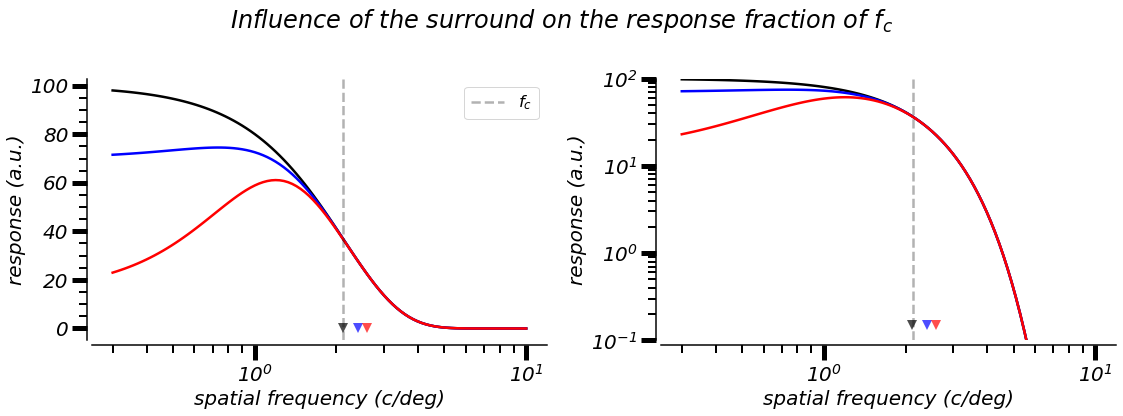

In [464]:
# DOG params
no_surr = [100, 0.15, 0, 2.5]
weak_surr = [100, 0.15, 0.3, 2.5]
strong_surr = [100, 0.15, 0.85, 2.5]
# sf values
vals = np.geomspace(0.3, 10, 100);

f, ax = plt.subplots(1, 2, figsize=(2*8,1*6))

# left side is log-linear; right is log-log
for i in range(2):

    ax[i].plot(vals, hf.DoGsach(*no_surr, stim_sf=vals)[0], 'k-')
    ax[i].plot(vals, hf.DoGsach(*weak_surr, stim_sf=vals)[0], 'b-')
    ax[i].plot(vals, hf.DoGsach(*strong_surr, stim_sf=vals)[0], 'r-')

    f_c = hf.dog_charFreq(no_surr, DoGmodel=1)

    ax[i].set_xscale('log')
    if i == 0:
        yval = 0;
    elif i == 1:
        yval = 0.15;
        ax[i].set_yscale('log')
        ax[i].set_ylim([0.1, 100])

    eFrac = 1/np.exp(1);

    ax[i].axvline(f_c, color='k', linestyle='--', alpha=0.3, label=r'$f_c$')
    eFs = [hf.sf_highCut(x, sfMod=1, frac=eFrac) for x in [no_surr, weak_surr, strong_surr]];

    clrs = ['k', 'b', 'r']
    [ax[i].plot(x, yval, 'v', color=c, markersize=10, alpha=0.7) for x,c in zip(eFs, clrs)];

    ax[i].set_xlabel('spatial frequency (c/deg)')
    ax[i].set_ylabel('response (a.u.)')

sns.despine(offset=5)
f.suptitle(r'Influence of the surround on the response fraction of $f_c$')

ax[0].legend(fontsize='small')
f.tight_layout()

saveName = "/01_00_simulation.pdf";
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


Alterante version of the above

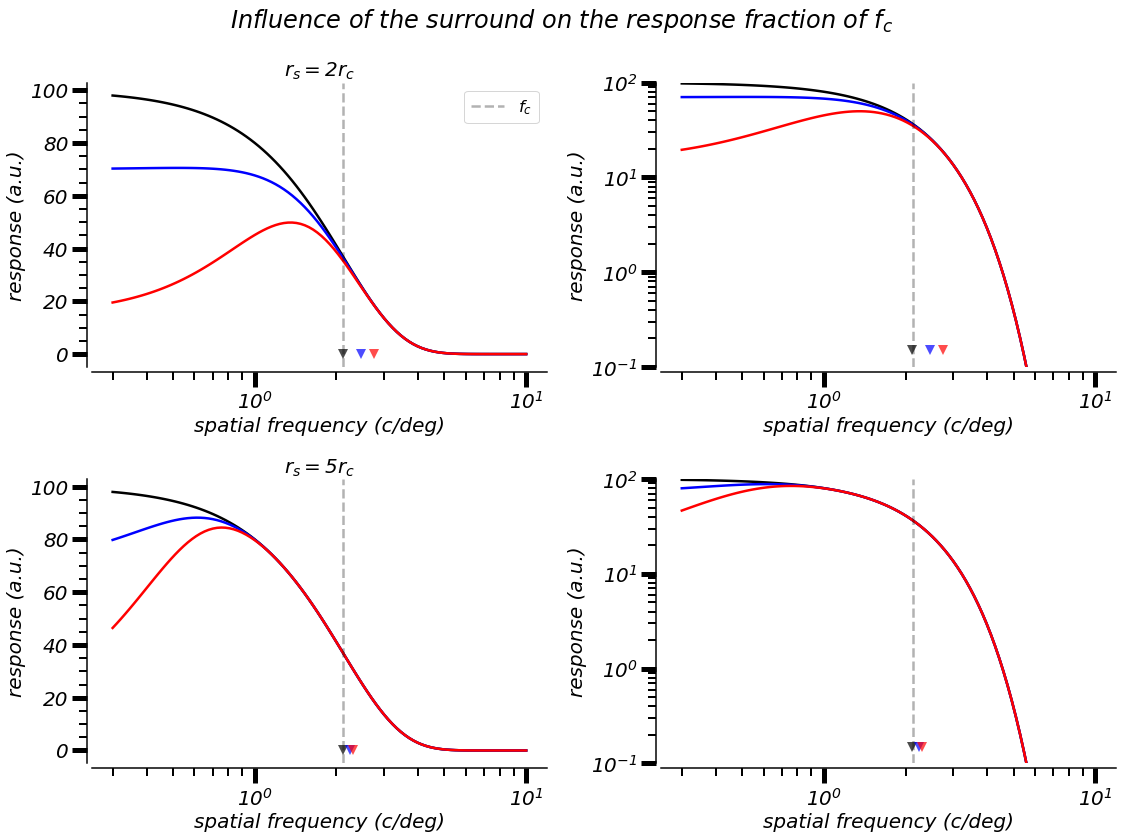

In [471]:
# sf values
vals = np.geomspace(0.3, 10, 100);

f, ax = plt.subplots(2, 2, figsize=(2*8,2*6))

for j in range(2):

    # DOG params
    no_surr = [100, 0.15, 0, (1+1.5*j)*2]
    weak_surr = [100, 0.15, 0.3, (1+1.5*j)*2]
    strong_surr = [100, 0.15, 0.85, (1+1.5*j)*2]

    # left side is log-linear; right is log-log
    for i in range(2):

        ax[j, i].plot(vals, hf.DoGsach(*no_surr, stim_sf=vals)[0], 'k-')
        ax[j, i].plot(vals, hf.DoGsach(*weak_surr, stim_sf=vals)[0], 'b-')
        ax[j, i].plot(vals, hf.DoGsach(*strong_surr, stim_sf=vals)[0], 'r-')

        f_c = hf.dog_charFreq(no_surr, DoGmodel=1)

        ax[j, i].set_xscale('log')
        if i == 0:
            yval = 0;
            ax[j, i].set_title(r'$r_s = %dr_c$' % (no_surr[-1]))
        elif i == 1:
            yval = 0.15;
            ax[j, i].set_yscale('log')
            ax[j, i].set_ylim([0.1, 100])

        eFrac = 1/np.exp(1);

        ax[j, i].axvline(f_c, color='k', linestyle='--', alpha=0.3, label=r'$f_c$')
        eFs = [hf.sf_highCut(x, sfMod=1, frac=eFrac) for x in [no_surr, weak_surr, strong_surr]];

        clrs = ['k', 'b', 'r']
        [ax[j, i].plot(x, yval, 'v', color=c, markersize=10, alpha=0.7) for x,c in zip(eFs, clrs)];

        ax[j, i].set_xlabel('spatial frequency (c/deg)')
        ax[j, i].set_ylabel('response (a.u.)')

sns.despine(offset=5)
f.suptitle(r'Influence of the surround on the response fraction of $f_c$')

ax[0,0].legend(fontsize='small')
f.tight_layout()

saveName = "/01_00alt_simulation.pdf";
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


#### First, all conditions

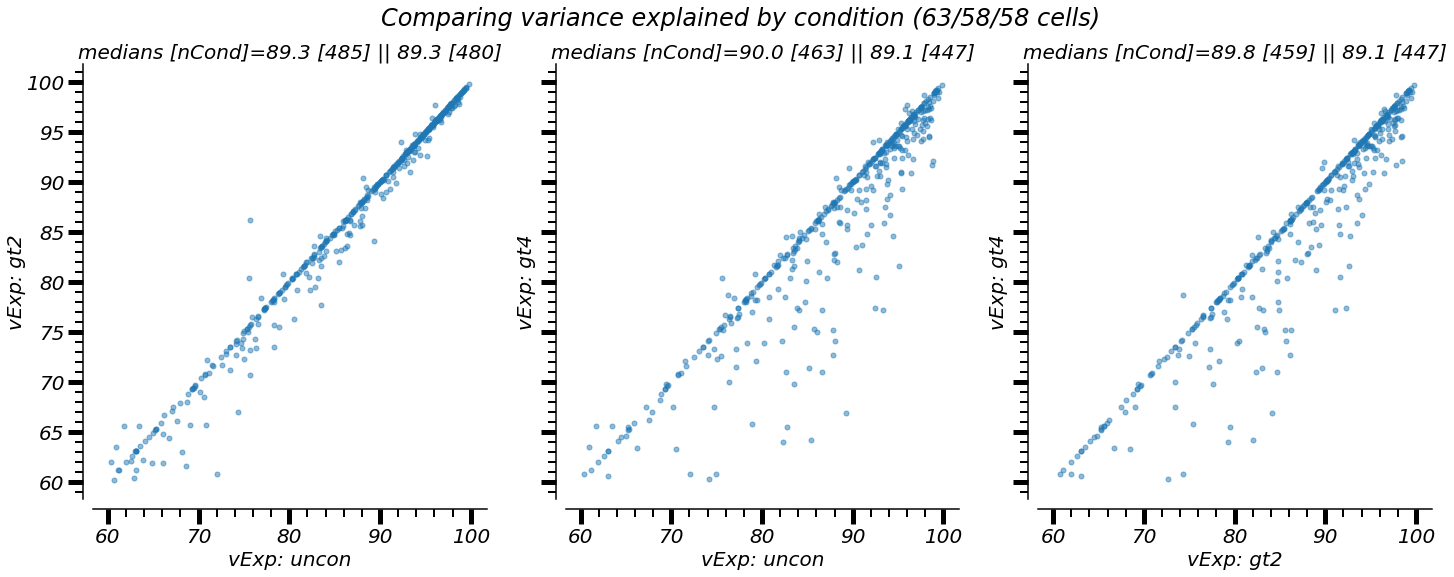

In [356]:
nrows, ncols = 1, 3;
f, ax = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), sharex=True, sharey=True)

nCells = [];

for i, (keyA, keyB) in enumerate(itertools.combinations(constr_name, 2)):
    
    # for each key, get the set of all variances explained
    # --- which first means, get all of the common cells (i.e. keys)
    cellsA = np.array([int(x) for x in all_jl[keyA].keys()])
    cellsB = np.array([int(x) for x in all_jl[keyB].keys()])
    common_cells = np.intersect1d(cellsA, cellsB);
    nCells.append(len(common_cells))
    
    # only get single grating fits
    vExp_A = np.hstack([all_jl[keyA][x]['metrics']['dog_varExpl'][0] for x in common_cells]);
    vExp_B = np.hstack([all_jl[keyB][x]['metrics']['dog_varExpl'][0] for x in common_cells]);
    
    nonNan = [np.where(~np.isnan(vExp_A))[0], np.where(~np.isnan(vExp_B))[0]]
    
    ax[i].scatter(vExp_A, vExp_B, alpha=0.5)
    ax[i].set_xlabel('vExp: %s' % keyA)
    ypad = 0 if i==0 else 20 # handle the overlap b/t y label and ticks on the other subplots
    ax[i].set_ylabel('vExp: %s' % keyB, labelpad=ypad)
    ax[i].set_title('medians [nCond]=%.1f [%d] || %.1f [%d]' % (np.median(vExp_A[nonNan[0]]), len(nonNan[0]),
                                                             np.median(vExp_B[nonNan[1]]), len(nonNan[1])))
sns.despine(offset=10)
f.suptitle('Comparing variance explained by condition (%02d/%02d/%02d cells)' % (*nCells, ));

saveName = "/01_01_vExp_byCond.pdf";
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

#### Then, averaging across all conditions _within_ a cell - first only high contrast, then all contrasts

Worst 5 cells for gt2 [vs. uncon]:
	#29: -10.34% change in vExp
	#27: -5.35% change in vExp
	#40: -4.64% change in vExp
	#31: -4.06% change in vExp
	#07: -3.90% change in vExp
Worst 5 cells for gt4 [vs. uncon]:
	#31: -24.86% change in vExp
	#63: -18.74% change in vExp
	#66: -16.18% change in vExp
	#08: -14.09% change in vExp
	#09: -10.50% change in vExp
Worst 5 cells for gt4 [vs. gt2]:
	#31: -21.68% change in vExp
	#63: -17.14% change in vExp
	#66: -14.06% change in vExp
	#08: -13.81% change in vExp
	#09: -8.80% change in vExp


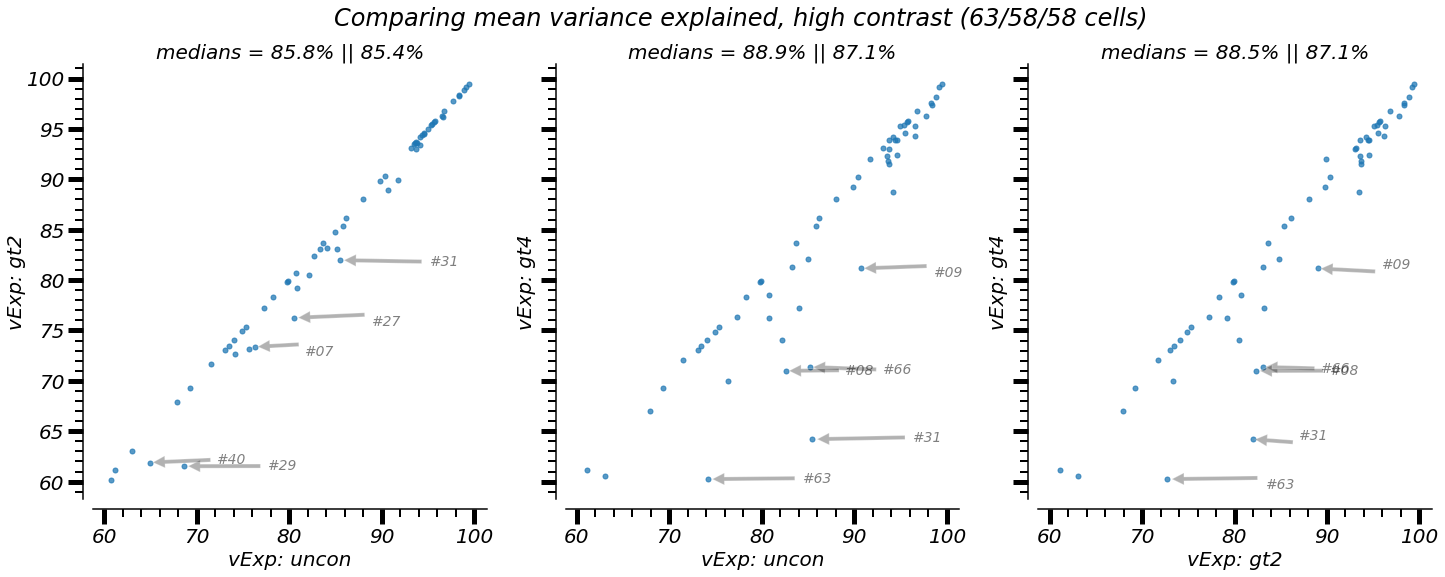

In [386]:
nrows, ncols = 1, 3;
f, ax = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), sharex=True, sharey=True)

nCells = [];

for i, (keyA, keyB) in enumerate(itertools.combinations(constr_name, 2)):
    
    # for each key, get the set of all variances explained
    # --- which first means, get all of the common cells (i.e. keys)
    cellsA = np.array([int(x) for x in all_jl[keyA].keys()])
    cellsB = np.array([int(x) for x in all_jl[keyB].keys()])
    common_cells = np.intersect1d(cellsA, cellsB);
    n_cells = len(common_cells)
    nCells.append(n_cells)
    
    mdnA = np.nan * np.zeros((n_cells, ));
    mdnB = np.nan * np.zeros((n_cells, ));
    
    for ii, c_i in enumerate(common_cells):
        # get the var. expl for the single grating fits for the current cell
        vExp_A = all_jl[keyA][c_i]['metrics']['dog_varExpl'][0,-1];
        vExp_B = all_jl[keyB][c_i]['metrics']['dog_varExpl'][0,-1];
        # find the common conditions and take the mean
        mdnA[ii] = vExp_A
        mdnB[ii] = vExp_B
    
    ax[i].scatter(mdnA, mdnB, alpha=0.75)
    ax[i].set_xlabel('vExp: %s' % keyA)
    ypad = 0 if i==0 else 20 # handle the overlap b/t y label and ticks on the other subplots
    ax[i].set_ylabel('vExp: %s' % keyB, labelpad=ypad)
    ax[i].set_title('medians = %.1f%% || %.1f%%' % (np.median(mdnA), np.median(mdnB)))

    # Also print out the 5 cells for which keyB does the worst compared to keyA
    print('Worst 5 cells for %s [vs. %s]:' % (keyB, keyA));
    diffs = (mdnB-mdnA)/100; # not normalized, just undoing the 100* after
#     diffs = (mdnB-mdnA)/mdnA
    ok = np.argsort(diffs);
    worst5 = [all_jl[keyB][common_cells[curr]]['metadata']['cellNum'] for curr in ok[0:5]]
    values = 100*diffs[ok[0:5]] # as percentage change
    [print('\t#%02d: %.2f%% change in vExp' % (x,y)) for x,y in zip(worst5, values)]
    
    # annotate the worst 5 on the scatter?
    for ind, cellN in zip(ok[0:5], worst5):
        coords = (mdnA[ind], mdnB[ind])
        jitter_x = 4+8*np.random.rand();
        jitter_y = -1*np.random.rand();
        jitter = (mdnA[ind]+jitter_x, mdnB[ind]+jitter_y)
        ax[i].annotate('#%02d' % cellN, xy=coords, xytext=jitter,arrowprops=dict(facecolor='black',shrink=0.05,alpha=0.3),
                       fontsize='x-small', alpha=0.5)
    
    # save the results
    if (keyA, keyB) not in all_jl:
        all_jl[(keyA, keyB)] = dict();
    # --- save for A, then for B
    all_jl[(keyA, keyB)]['%s_vExp_hiCon' % keyA] = mdnA
    all_jl[(keyA, keyB)]['%s_vExp_hiCon' % keyB] = mdnB
    all_jl[(keyA, keyB)]['worst_5_ind_hiCon'] = ok[0:5]
    all_jl[(keyA, keyB)]['worst_5_label_hiCon'] = worst5
    
sns.despine(offset=10)
f.suptitle('Comparing mean variance explained, high contrast (%02d/%02d/%02d cells)' % (*nCells, ));

saveName = "/01_02_vExp_hiCon.pdf";
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close();

Then all contrasts

Worst 5 cells for gt2 [vs. uncon]:
	#39: -3.24% change in vExp
	#47: -2.75% change in vExp
	#09: -2.56% change in vExp
	#22: -2.25% change in vExp
	#06: -2.06% change in vExp
Worst 5 cells for gt4 [vs. uncon]:
	#09: -11.51% change in vExp
	#31: -9.96% change in vExp
	#66: -7.70% change in vExp
	#22: -7.53% change in vExp
	#26: -7.20% change in vExp
Worst 5 cells for gt4 [vs. gt2]:
	#09: -10.12% change in vExp
	#31: -8.09% change in vExp
	#66: -6.84% change in vExp
	#26: -6.75% change in vExp
	#63: -6.32% change in vExp


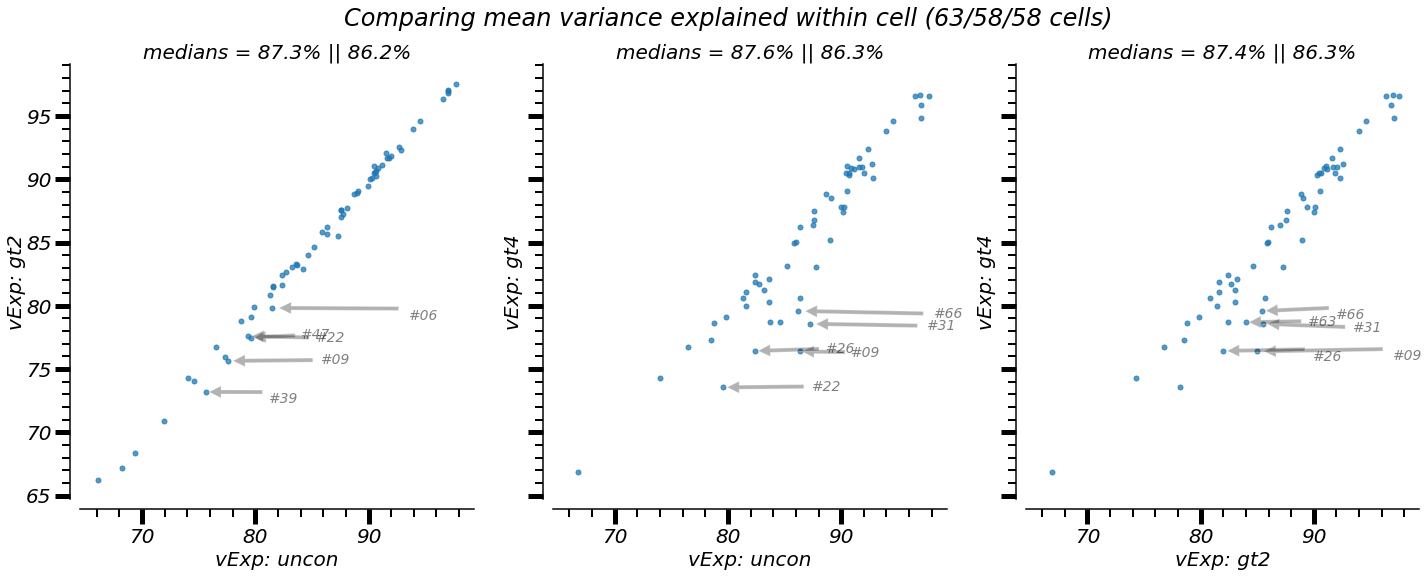

In [387]:
nrows, ncols = 1, 3;
f, ax = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), sharex=True, sharey=True)

nCells = [];

for i, (keyA, keyB) in enumerate(itertools.combinations(constr_name, 2)):
    
    # for each key, get the set of all variances explained
    # --- which first means, get all of the common cells (i.e. keys)
    cellsA = np.array([int(x) for x in all_jl[keyA].keys()])
    cellsB = np.array([int(x) for x in all_jl[keyB].keys()])
    common_cells = np.intersect1d(cellsA, cellsB);
    n_cells = len(common_cells)
    nCells.append(n_cells)
    
    mdnA = np.nan * np.zeros((n_cells, ));
    mdnB = np.nan * np.zeros((n_cells, ));
    
    for ii, c_i in enumerate(common_cells):
        # get the var. expl for the single grating fits for the current cell
        vExp_A = all_jl[keyA][c_i]['metrics']['dog_varExpl'][0];
        vExp_B = all_jl[keyB][c_i]['metrics']['dog_varExpl'][0];
        # find the common conditions and take the mean
        val_conds = np.logical_and(~np.isnan(vExp_A), ~np.isnan(vExp_B));
        mdnA[ii] = np.mean(vExp_A[val_conds])
        mdnB[ii] = np.mean(vExp_B[val_conds])
    
    ax[i].scatter(mdnA, mdnB, alpha=0.75)
    ax[i].set_xlabel('vExp: %s' % keyA)
    ypad = 0 if i==0 else 20 # handle the overlap b/t y label and ticks on the other subplots
    ax[i].set_ylabel('vExp: %s' % keyB, labelpad=ypad)
    ax[i].set_title('medians = %.1f%% || %.1f%%' % (np.median(mdnA), np.median(mdnB)))

    # Also print out the 5 cells for which keyB does the worst compared to keyA
    print('Worst 5 cells for %s [vs. %s]:' % (keyB, keyA));
    diffs = (mdnB-mdnA)/100 # not doing shift as percentage, just undoing the upcoming 100*
#     diffs = (mdnB-mdnA)/mdnA
    ok = np.argsort(diffs);
    worst5 = [all_jl[keyB][common_cells[curr]]['metadata']['cellNum'] for curr in ok[0:5]]
    values = 100*diffs[ok[0:5]] # as percentage change
    [print('\t#%02d: %.2f%% change in vExp' % (x,y)) for x,y in zip(worst5, values)]
    
    # annotate the worst 5 on the scatter?
    for ind, cellN in zip(ok[0:5], worst5):
        coords = (mdnA[ind], mdnB[ind])
        jitter_x = 4+8*np.random.rand();
        jitter_y = -1*np.random.rand();
        jitter = (mdnA[ind]+jitter_x, mdnB[ind]+jitter_y)
        ax[i].annotate('#%02d' % cellN, xy=coords, xytext=jitter,arrowprops=dict(facecolor='black',shrink=0.05,alpha=0.3),
                       fontsize='x-small', alpha=0.5)
    
    # save the results
    if (keyA, keyB) not in all_jl:
        all_jl[(keyA, keyB)] = dict();
    # --- save for A, then for B
    all_jl[(keyA, keyB)]['%s_vExp_allCon' % keyA] = mdnA
    all_jl[(keyA, keyB)]['%s_vExp_allCon' % keyB] = mdnB
    all_jl[(keyA, keyB)]['worst_5_ind_allCon'] = ok[0:5]
    all_jl[(keyA, keyB)]['worst_5_label_allCon'] = worst5
    
sns.despine(offset=10)
f.suptitle('Comparing mean variance explained within cell (%02d/%02d/%02d cells)' % (*nCells, ));

saveName = "/01_03_vExp_allCon.pdf";
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close();

### 2. Does the correspondence between $f_{70}$ and $f_c$ improve with surround restrictions?
As above, but now we'll ask how the correspondence between $f_{70}$ and $f_c$ varies under the different fits

##### All conditions across all cells (single gratings, only)

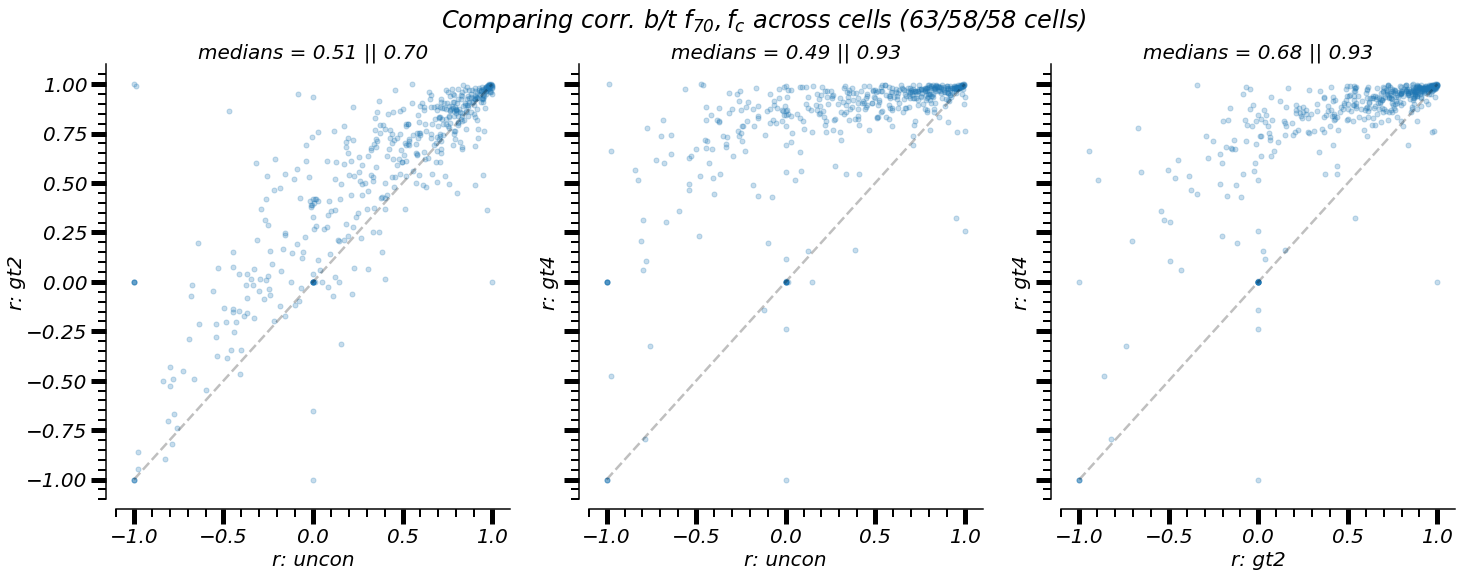

In [391]:
nrows, ncols = 1, 3;
f, ax = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), sharex=True, sharey=True)

nCells = [];

nBoots = all_jl['uncon'][0]['metrics']['boot_dog_pSf_values'].shape[-1]
frac = 0.25; # a metric should be defined in at least 25% of boot. iters to count

for i, (keyA, keyB) in enumerate(itertools.combinations(constr_name, 2)):
    
    # for each key, get the set of all variances explained
    # --- which first means, get all of the common cells (i.e. keys)
    cellsA = np.array([int(x) for x in all_jl[keyA].keys()])
    cellsB = np.array([int(x) for x in all_jl[keyB].keys()])
    common_cells = np.intersect1d(cellsA, cellsB);
    nCells.append(len(common_cells))
    
    corrsA = [];
    corrsB = [];
    
    # only get single grating fits
    for cc in common_cells:
        # --- but do within conditions???
        f70_A = all_jl[keyA][cc]['metrics']['boot_dog_sf70_values'][0]
        fc_A = all_jl[keyA][cc]['metrics']['boot_dog_charFreq_values'][0]
        f70_B = all_jl[keyB][cc]['metrics']['boot_dog_sf70_values'][0]
        fc_B = all_jl[keyB][cc]['metrics']['boot_dog_charFreq_values'][0]
        # make sure we only look at the "valid" conditions (i.e. enough boot values)
        n_nonNan_A = np.sum(~np.isnan(f70_A), axis=1)
        n_nonNan_B = np.sum(~np.isnan(f70_B), axis=1)
        val_inds = np.where(np.logical_and(n_nonNan_A > frac*nBoots, n_nonNan_B > frac*nBoots))[0];
        
        for vi in val_inds:
            val_a = np.logical_and(~np.isnan(f70_A[vi]), ~np.isnan(fc_A[vi]));
            val_b = np.logical_and(~np.isnan(f70_B[vi]), ~np.isnan(fc_B[vi]));
            corr_a = np.corrcoef(f70_A[vi,val_a], fc_A[vi,val_a])[0,1]
            corr_b = np.corrcoef(f70_B[vi,val_b], fc_B[vi,val_b])[0,1]
        
            corrsA.append(corr_a)
            corrsB.append(corr_b);
        
    ax[i].scatter(corrsA, corrsB, alpha=0.25)
    ax[i].set_xlabel('r: %s' % keyA)
    ypad = 0 if i==0 else 20 # handle the overlap b/t y label and ticks on the other subplots
    ax[i].set_ylabel('r: %s' % keyB, labelpad=ypad)
    ax[i].set_title('medians = %.2f || %.2f' % (np.nanmedian(corrsA), np.nanmedian(corrsB)));

    # put reference line
    ax[i].plot([-1, 1], [-1, 1], 'k--', alpha=0.25)

sns.despine(offset=10)
f.suptitle(r'Comparing corr. b/t $f_{70},f_c$ across cells (%02d/%02d/%02d cells)' % (*nCells, ));

saveName = "/01_04_fc_f70_allCond.pdf";
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

##### For this one, just high contrast, single gratings

Best 5 cells for gt2 [vs. uncon]:
	#31: 0.43 change in r
	#07: 0.60 change in r
	#73: 0.66 change in r
	#81: 0.94 change in r
	#72: 2.00 change in r
Best 5 cells for gt4 [vs. uncon]:
	#67: 1.03 change in r
	#12: 1.03 change in r
	#22: 1.06 change in r
	#13: 1.11 change in r
	#07: 1.33 change in r
Best 5 cells for gt4 [vs. gt2]:
	#66: 0.81 change in r
	#13: 0.84 change in r
	#65: 0.90 change in r
	#79: 0.93 change in r
	#67: 1.01 change in r


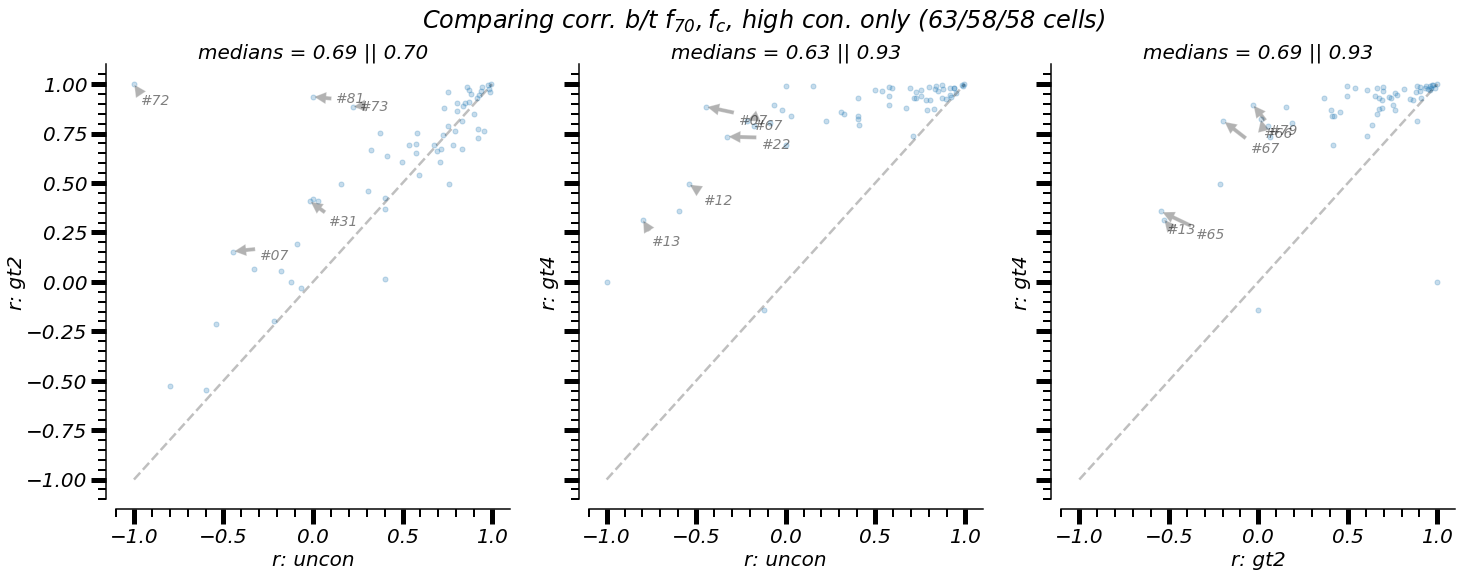

In [418]:
nrows, ncols = 1, 3;
f, ax = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), sharex=True, sharey=True)

nCells = [];

nBoots = all_jl['uncon'][0]['metrics']['boot_dog_pSf_values'].shape[-1]
frac = 0.25; # a metric should be defined in at least 25% of boot. iters to count

for i, (keyA, keyB) in enumerate(itertools.combinations(constr_name, 2)):
    
    # for each key, get the set of all variances explained
    # --- which first means, get all of the common cells (i.e. keys)
    cellsA = np.array([int(x) for x in all_jl[keyA].keys()])
    cellsB = np.array([int(x) for x in all_jl[keyB].keys()])
    common_cells = np.intersect1d(cellsA, cellsB);
    nCells.append(len(common_cells))
    
    corrsA = np.nan*np.zeros((nCells[i], ))
    corrsB = np.nan*np.zeros((nCells[i], ))
    
    # only get single grating fits
    for ii,cc in enumerate(common_cells):
        # --- but do within conditions???
        f70_A = all_jl[keyA][cc]['metrics']['boot_dog_sf70_values'][0]
        fc_A = all_jl[keyA][cc]['metrics']['boot_dog_charFreq_values'][0]
        f70_B = all_jl[keyB][cc]['metrics']['boot_dog_sf70_values'][0]
        fc_B = all_jl[keyB][cc]['metrics']['boot_dog_charFreq_values'][0]
        # make sure we only look at the "valid" conditions (i.e. enough boot values)

        val_a = np.logical_and(~np.isnan(f70_A[-1]), ~np.isnan(fc_A[-1]));
        val_b = np.logical_and(~np.isnan(f70_B[-1]), ~np.isnan(fc_B[-1]));
        corr_a = np.corrcoef(f70_A[-1,val_a], fc_A[-1,val_a])[0,1]
        corr_b = np.corrcoef(f70_B[-1,val_b], fc_B[-1,val_b])[0,1]
        
        corrsA[ii] = corr_a
        corrsB[ii] = corr_b
        
    ax[i].scatter(corrsA, corrsB, alpha=0.25)
    ax[i].set_xlabel('r: %s' % keyA)
    ypad = 0 if i==0 else 20 # handle the overlap b/t y label and ticks on the other subplots
    ax[i].set_ylabel('r: %s' % keyB, labelpad=ypad)
    ax[i].set_title('medians = %.2f || %.2f' % (np.nanmedian(corrsA), np.nanmedian(corrsB)));
    
    #----------- annotation
    # Also print out the 5 cells for which keyB does the best compared to keyA
    print('Best 5 cells for %s [vs. %s]:' % (keyB, keyA));
    diffs = corrsB-corrsA;
    ok = np.argsort(diffs);
    best5 = [all_jl[keyB][common_cells[curr]]['metadata']['cellNum'] for curr in ok[-5:]]
    values = diffs[ok[-5:]]
    [print('\t#%02d: %.2f change in r' % (x,y)) for x,y in zip(best5, values)]

    # and annotate the best 5 on the scatter?
    for ind, cellN in zip(ok[-5:], best5):
        coords = (corrsA[ind], corrsB[ind])
        jitter_x = 0.2*np.random.rand();
        jitter_y = -0.2*np.random.rand();
        jitter = (coords[0]+jitter_x, coords[1]+jitter_y)
        ax[i].annotate('#%02d' % cellN, xy=coords, xytext=jitter,arrowprops=dict(facecolor='black',shrink=0.05,alpha=0.3),
                       fontsize='x-small', alpha=0.5)
    #-----------
    
    # save the results
    if (keyA, keyB) not in all_jl:
        all_jl[(keyA, keyB)] = dict();
    # --- save for A, then for B
    all_jl[(keyA, keyB)]['%s_corr_hiCon' % keyA] = corrsA
    all_jl[(keyA, keyB)]['%s_corr_hiCon' % keyB] = corrsB
    all_jl[(keyA, keyB)]['best_5_ind_hiCon'] = ok[-5:]
    all_jl[(keyA, keyB)]['best_5_label_hiCon'] = best5
    all_jl[(keyA, keyB)]['cells_hiCon'] = common_cells;

    # put reference line
    ax[i].plot([-1, 1], [-1, 1], 'k--', alpha=0.25)
    
sns.despine(offset=10)
f.suptitle(r'Comparing corr. b/t $f_{70},f_c$, high con. only (%02d/%02d/%02d cells)' % (*nCells, ));

saveName = "/01_05_fc_f70_hiCon.pdf";
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

##### Per cell, all single gratings

Best 5 cells for gt2 [vs. uncon]:
	#32: 0.55 change in r
	#31: 0.58 change in r
	#72: 0.82 change in r
	#81: 0.86 change in r
	#74: 1.00 change in r
Best 5 cells for gt4 [vs. uncon]:
	#67: 1.00 change in r
	#74: 1.00 change in r
	#31: 1.03 change in r
	#79: 1.08 change in r
	#07: 1.09 change in r
Best 5 cells for gt4 [vs. gt2]:
	#12: 0.71 change in r
	#66: 0.72 change in r
	#65: 0.78 change in r
	#79: 0.79 change in r
	#73: 0.85 change in r


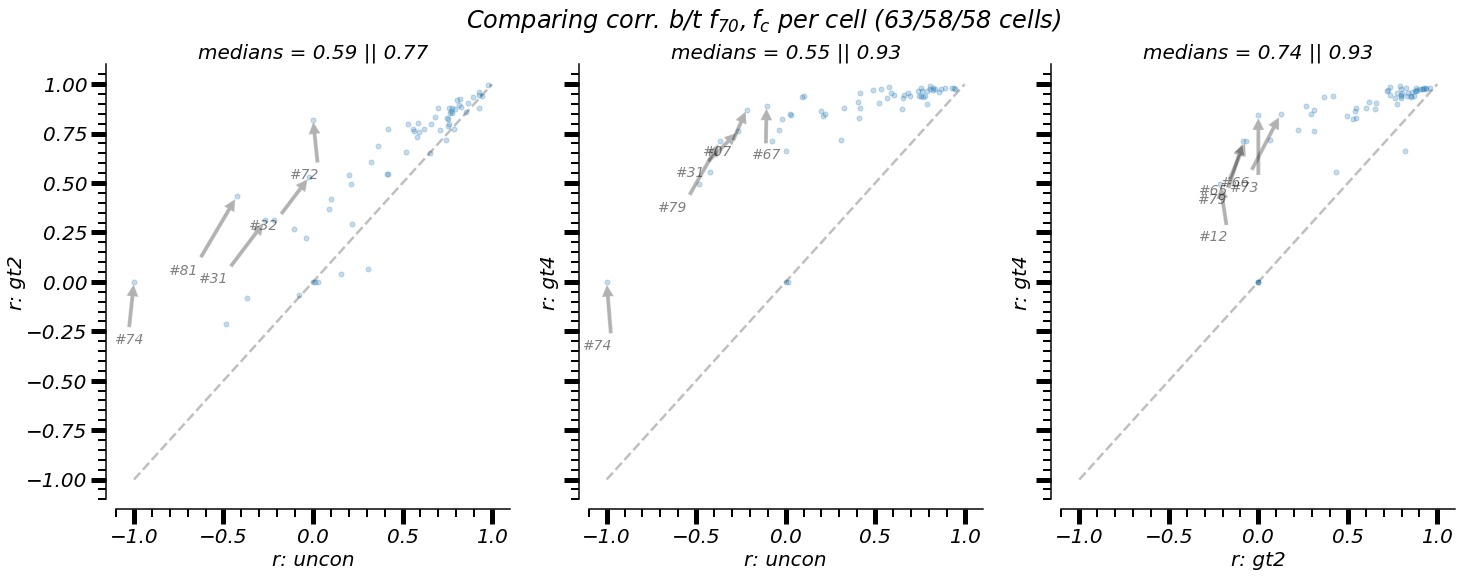

In [419]:
nrows, ncols = 1, 3;
f, ax = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), sharex=True, sharey=True)

nCells = [];

nBoots = all_jl['uncon'][0]['metrics']['boot_dog_pSf_values'].shape[-1]
frac = 0.25; # a metric should be defined in at least 25% of boot. iters to count

for i, (keyA, keyB) in enumerate(itertools.combinations(constr_name, 2)):
    
    # for each key, get the set of all variances explained
    # --- which first means, get all of the common cells (i.e. keys)
    cellsA = np.array([int(x) for x in all_jl[keyA].keys()])
    cellsB = np.array([int(x) for x in all_jl[keyB].keys()])
    common_cells = np.intersect1d(cellsA, cellsB);
    nCells.append(len(common_cells))
    
    corrsA = np.nan*np.zeros((nCells[i], ))
    corrsB = np.nan*np.zeros((nCells[i], ))
    
    # only get single grating fits
    for ii, cc in enumerate(common_cells):
        # --- but do within conditions???
        f70_A = all_jl[keyA][cc]['metrics']['boot_dog_sf70_values'][0]
        fc_A = all_jl[keyA][cc]['metrics']['boot_dog_charFreq_values'][0]
        f70_B = all_jl[keyB][cc]['metrics']['boot_dog_sf70_values'][0]
        fc_B = all_jl[keyB][cc]['metrics']['boot_dog_charFreq_values'][0]
        # make sure we only look at the "valid" conditions (i.e. enough boot values)
        n_nonNan_A = np.sum(~np.isnan(f70_A), axis=1)
        n_nonNan_B = np.sum(~np.isnan(f70_B), axis=1)
        val_inds = np.where(np.logical_and(n_nonNan_A > frac*nBoots, n_nonNan_B > frac*nBoots))[0];
        
        curr_a = [];
        curr_b = [];
        
        for vi in val_inds:
            val_a = np.logical_and(~np.isnan(f70_A[vi]), ~np.isnan(fc_A[vi]));
            val_b = np.logical_and(~np.isnan(f70_B[vi]), ~np.isnan(fc_B[vi]));
            corr_a = np.corrcoef(f70_A[vi,val_a], fc_A[vi,val_a])[0,1]
            corr_b = np.corrcoef(f70_B[vi,val_b], fc_B[vi,val_b])[0,1]
            
            curr_a.append(corr_a);
            curr_b.append(corr_b);
        
        corrsA[ii] = np.nanmedian(curr_a)
        corrsB[ii] = np.nanmedian(curr_b)
        
    ax[i].scatter(corrsA, corrsB, alpha=0.25)
    ax[i].set_xlabel('r: %s' % keyA)
    ypad = 0 if i==0 else 20 # handle the overlap b/t y label and ticks on the other subplots
    ax[i].set_ylabel('r: %s' % keyB, labelpad=ypad)
    ax[i].set_title('medians = %.2f || %.2f' % (np.nanmedian(corrsA), np.nanmedian(corrsB)));

    #----------- annotation
    # Also print out the 5 cells for which keyB does the best compared to keyA
    print('Best 5 cells for %s [vs. %s]:' % (keyB, keyA));
    diffs = corrsB-corrsA;
    ok = np.argsort(diffs);
    best5 = [all_jl[keyB][common_cells[curr]]['metadata']['cellNum'] for curr in ok[-5:]]
    values = diffs[ok[-5:]]
    [print('\t#%02d: %.2f change in r' % (x,y)) for x,y in zip(best5, values)]

    # and annotate the best 5 on the scatter?
    for ind, cellN in zip(ok[-5:], best5):
        coords = (corrsA[ind], corrsB[ind])
        jitter_x = -0.4*np.random.rand();
        jitter_y = -0.2-0.2*np.random.rand();
        jitter = (coords[0]+jitter_x, coords[1]+jitter_y)
        ax[i].annotate('#%02d' % cellN, xy=coords, xytext=jitter,arrowprops=dict(facecolor='black',shrink=0.05,alpha=0.3),
                       fontsize='x-small', alpha=0.5)
    #-----------
    # save the results
    if (keyA, keyB) not in all_jl:
        all_jl[(keyA, keyB)] = dict();
    # --- save for A, then for B
    all_jl[(keyA, keyB)]['%s_corr_allCon' % keyA] = corrsA
    all_jl[(keyA, keyB)]['%s_corr_allCon' % keyB] = corrsB
    all_jl[(keyA, keyB)]['best_5_ind_allCon'] = ok[-5:]
    all_jl[(keyA, keyB)]['best_5_label_allCon'] = best5
    all_jl[(keyA, keyB)]['cells_allCon'] = common_cells;
    
    # put reference line
    ax[i].plot([-1, 1], [-1, 1], 'k--', alpha=0.25)

sns.despine(offset=10)
f.suptitle(r'Comparing corr. b/t $f_{70},f_c$ per cell (%02d/%02d/%02d cells)' % (*nCells, ));

saveName = "/01_06_fc_f70_allCond.pdf";
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

And again, but now correlating not across bootstrap samples within a condition, but across conditions, within a cell

Best 5 cells for gt2 [vs. uncon]:
	#29: 0.43 change in r
	#49: 0.51 change in r
	#47: 0.55 change in r
	#01: 0.56 change in r
	#07: 0.81 change in r
Best 5 cells for gt4 [vs. uncon]:
	#17: 0.89 change in r
	#07: 0.89 change in r
	#44: 0.90 change in r
	#47: 1.03 change in r
	#41: 1.14 change in r
Best 5 cells for gt4 [vs. gt2]:
	#47: 0.48 change in r
	#55: 0.50 change in r
	#44: 0.53 change in r
	#17: 0.59 change in r
	#41: 0.84 change in r


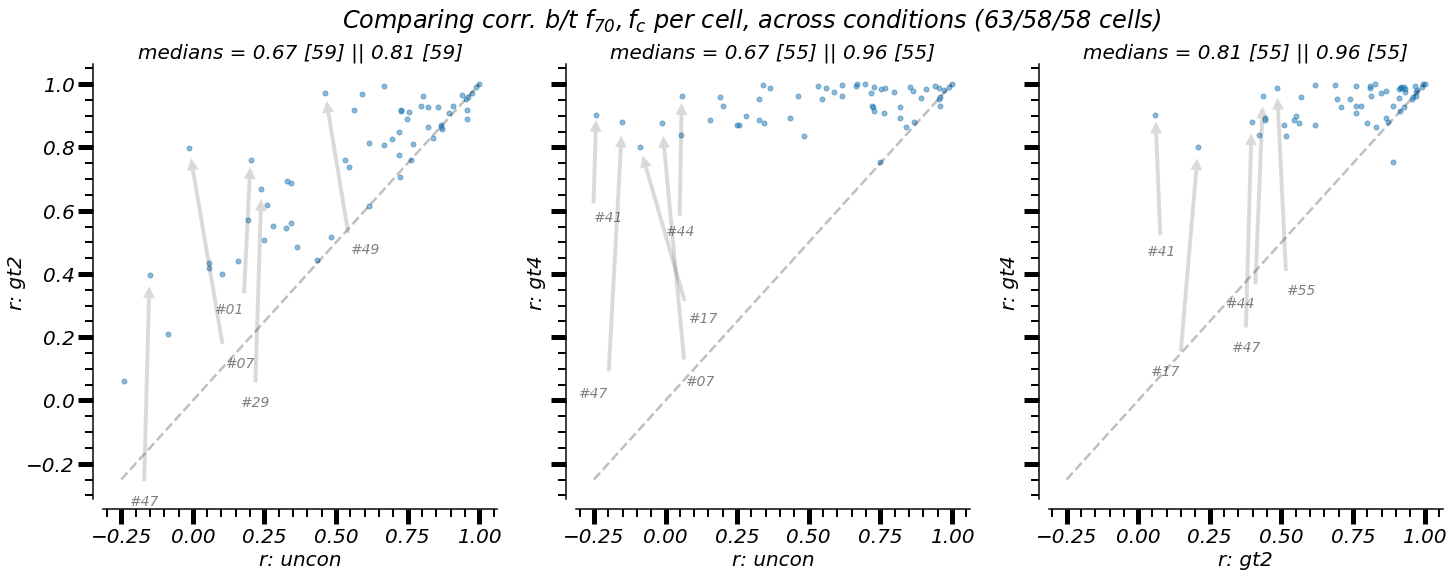

In [628]:
nrows, ncols = 1, 3;
f, ax = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), sharex=True, sharey=True)

nCells = [];

for i, (keyA, keyB) in enumerate(itertools.combinations(constr_name, 2)):
    
    # for each key, get the set of all variances explained
    # --- which first means, get all of the common cells (i.e. keys)
    cellsA = np.array([int(x) for x in all_jl[keyA].keys()])
    cellsB = np.array([int(x) for x in all_jl[keyB].keys()])
    common_cells = np.intersect1d(cellsA, cellsB);
    nCells.append(len(common_cells))
    
    corrsA = np.nan*np.zeros((nCells[i], ))
    corrsB = np.nan*np.zeros((nCells[i], ))
    
    # only get single grating fits
    for ii, cc in enumerate(common_cells):
        # --- but do within conditions???
        f70_A = all_jl[keyA][cc]['metrics']['dog_sf70'][0]
        fc_A = all_jl[keyA][cc]['metrics']['dog_charFreq'][0]
        f70_B = all_jl[keyB][cc]['metrics']['dog_sf70'][0]
        fc_B = all_jl[keyB][cc]['metrics']['dog_charFreq'][0]
        # make sure we only look at the "valid" conditions (i.e. enough boot values)
        
        val_a = np.logical_and(~np.isnan(f70_A), ~np.isnan(fc_A));
        val_b = np.logical_and(~np.isnan(f70_B), ~np.isnan(fc_B));
        corr_a = np.corrcoef(f70_A[val_a], fc_A[val_a])[0,1]
        corr_b = np.corrcoef(f70_B[val_b], fc_B[val_b])[0,1]
        
        if np.sum(val_a) < 2 or np.sum(val_b) < 2:
            continue; # need at least 3 valid contrasts for each comparison
            
        corrsA[ii] = corr_a
        corrsB[ii] = corr_b
        
    ax[i].scatter(corrsA, corrsB, alpha=0.5)
#     sns.jointplot(corrsA, corrsB, kind='kde', ax=ax[i])
    ax[i].set_xlabel('r: %s' % keyA)
    ypad = 0 if i==0 else 20 # handle the overlap b/t y label and ticks on the other subplots
    ax[i].set_ylabel('r: %s' % keyB, labelpad=ypad)
    ax[i].set_title('medians = %.2f [%d] || %.2f [%d]' % (np.nanmedian(corrsA), np.sum(~np.isnan(corrsA)), 
                                                          np.nanmedian(corrsB), np.sum(~np.isnan(corrsB))));

    #----------- annotation
    #'''
    # Also print out the 5 cells for which keyB does the best compared to keyA
    print('Best 5 cells for %s [vs. %s]:' % (keyB, keyA));
    vals = np.logical_and(~np.isnan(corrsA), ~np.isnan(corrsB));
    diffs = corrsB-corrsA;
    ok = np.argsort(diffs[vals]);
    best5 = [all_jl[keyB][common_cells[vals][curr]]['metadata']['cellNum'] for curr in ok[-5:]]
    values = diffs[vals][ok[-5:]]
    [print('\t#%02d: %.2f change in r' % (x,y)) for x,y in zip(best5, values)]

    # and annotate the best 5 on the scatter?
    for ind, cellN in zip(ok[-5:], best5):
        coords = (corrsA[vals][ind], corrsB[vals][ind])
        jitter_x = +0.2-0.4*np.random.rand();
        jitter_y = -0.3-0.6*np.random.rand();
        jitter = (coords[0]+jitter_x, coords[1]+jitter_y)
        ax[i].annotate('#%02d' % cellN, xy=coords, xytext=jitter,arrowprops=dict(facecolor='black',shrink=0.05,alpha=0.15),
                       fontsize='x-small', alpha=0.5)
    #'''
    #-----------
    # save the results
    if (keyA, keyB) not in all_jl:
        all_jl[(keyA, keyB)] = dict();
    # --- save for A, then for B
    all_jl[(keyA, keyB)]['%s_corr_allCon' % keyA] = corrsA
    all_jl[(keyA, keyB)]['%s_corr_allCon' % keyB] = corrsB
    all_jl[(keyA, keyB)]['best_5_ind_allCon'] = ok[-5:]
    all_jl[(keyA, keyB)]['best_5_label_allCon'] = best5
    all_jl[(keyA, keyB)]['cells_allCon'] = common_cells;
    
    # put reference line
    ax[i].plot([-0.25, 1], [-0.25, 1], 'k--', alpha=0.25)

sns.despine(offset=10)
f.suptitle(r'Comparing corr. b/t $f_{70},f_c$ per cell, across conditions (%02d/%02d/%02d cells)' % (*nCells, ));

saveName = "/01_06alt_fc_f70_allCond_notBoot.pdf";
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### 3. Do the reductions in explained variance correlate with changes in the $f_{70}, f_c$ correlation?

In [535]:
from scipy.optimize import curve_fit

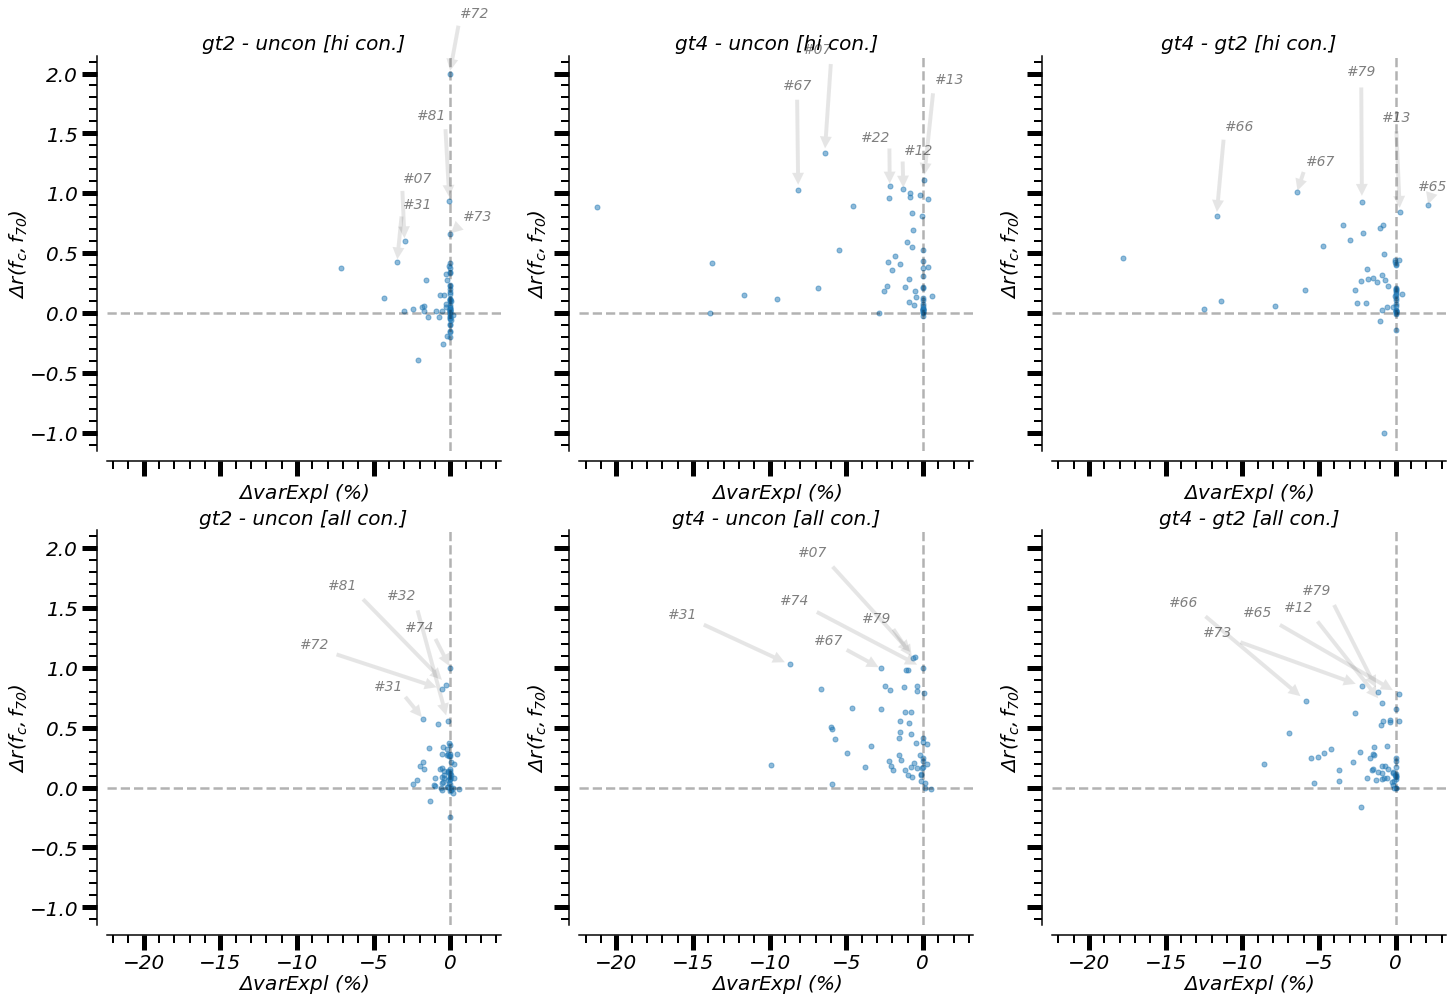

In [549]:
# the plot will be 2x3 - 3 for the 3 comparisons; and 2 for comparing delta(vExp) with delta(corr) at high [top] and all [bottom] contrasts
nrows, ncols = 2, 3;
f, ax = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), sharex=True, sharey=True)

# do we want to annotate the cells with the worst reduction varExpl? Or the best improvement in r(fc, f70)?
# annotate = 'worst';
annotate = 'best';
annotateStr = 'VarExpl' if 'worst' in annotate else 'Corr';

norm_changes = 0;

for i, (keyA, keyB) in enumerate(itertools.combinations(constr_name, 2)):
    
    curr_vals = all_jl[(keyA, keyB)];
    #######
    ### first, the top row -- compare change in vExp with change in correlation measured only at high contrast
    #######
    varExpl = curr_vals['%s_vExp_hiCon' % keyB] - curr_vals['%s_vExp_hiCon' % keyA]; # change in var. expl from A to B
    if norm_changes:
        scalar = 100; # to turn into percentages
        varExpl = varExpl / curr_vals['%s_vExp_hiCon' % keyA];
    else:
        scalar = 1;
       
    corrs = curr_vals['%s_corr_hiCon' % keyB] - curr_vals['%s_corr_hiCon' % keyA]; # change in var. expl from A to B  
    if norm_changes:
        # make sure that no almost-zero correlation blows everything up, so if a corr is close to zero
        corrs = corrs / np.sign(curr_vals['%s_corr_hiCon' % keyA])*np.maximum(1e-2, np.abs(curr_vals['%s_corr_hiCon' % keyA]));
    ax[0, i].scatter(scalar*varExpl, scalar*corrs, alpha=0.5)
       
    ### And annotate the same worst 5 (i.e. the ones whose varExpl got worse from A-->B)
    inds, labs = curr_vals['%s_5_ind_hiCon' % annotate], curr_vals['%s_5_label_hiCon' % annotate]
    for ind, cellN in zip(inds, labs):
        coords = (scalar*varExpl[ind], scalar*corrs[ind])
        jitter_x = +1-4*np.random.rand();
        jitter_y = 0.1+1*np.random.rand();
        jitter = (coords[0]+jitter_x, coords[1]+jitter_y)
        ax[0, i].annotate('#%02d' % cellN, xy=coords, xytext=jitter,arrowprops=dict(facecolor='black',shrink=0.05,alpha=0.1),
                       fontsize='x-small', alpha=0.5)

    # do simple linear regression?
#     def lin(x, m, b):
#         return m*x + b;
#     pms = curve_fit(lin, xdata=varExpl, ydata=corrs)[0]
#     vExp_values = np.linspace(np.min(varExpl), np.max(varExpl), 50);
#     ax[0,i].plot(vExp_values, lin(vExp_values, *pms), 'k--')
        
    # do a PCA, draw eigenvectors?
#     as_matr = np.stack((scalar*varExpl, scalar*corrs), axis=1);
#     # --- mean center the data
#     centered = as_matr - np.mean(as_matr, axis=0);
#     # --- get the covariance matrix
#     cov = np.cov(centered, rowvar=False)
#     eigen_vals , eigen_vecs = np.linalg.eigh(cov)
#     # sort the eigenvals (desc.)
#     inds = np.argsort(eigen_val)[::-1]
#     eigen_vals = eigen_vals[inds]
#     eigen_vecs = eigen_vec[inds]
#     vec1 = [0,0, *np.dot(eigen_vals[0], eigen_vecs[:,0])]
#     vec2 = [0,0, *np.dot(eigen_vals[1], eigen_vecs[:,1])]
#     X, Y, U, V = zip(*np.array([vec1, vec2]))
#     ax[0, i].quiver(X, Y, U, V)
        
    #######
    # then, the bottom row -- compare change in vExp with change in correlation measured at all contrasts
    #######
    varExpl = curr_vals['%s_vExp_allCon' % keyB] - curr_vals['%s_vExp_allCon' % keyA]; # change in var. expl from A to B
    if norm_changes:
        scalar = 100; # to turn into percentages
        varExpl = varExpl / curr_vals['%s_vExp_allCon' % keyA];
    else:
        scalar = 1;

    
    corrs = curr_vals['%s_corr_allCon' % keyB] - curr_vals['%s_corr_allCon' % keyA]; # change in var. expl from A to B
    if norm_changes:
        # make sure that no almost-zero correlation blows everything up, so if a corr is close to zero
        corrs = corrs / np.sign(curr_vals['%s_corr_allCon' % keyA])*np.maximum(1e-2, np.abs(curr_vals['%s_corr_allCon' % keyA]));
    ax[1, i].scatter(scalar*varExpl, scalar*corrs, alpha=0.5)
    
    ### And annotate the same worst 5 (i.e. the ones whose varExpl got worse from A-->B)
    inds, labs = curr_vals['%s_5_ind_allCon' % annotate], curr_vals['%s_5_label_allCon' % annotate]
    for ind, cellN in zip(inds, labs):
        coords = (scalar*varExpl[ind], scalar*corrs[ind])
        jitter_x = -2-9*np.random.rand();
        jitter_y = 0.1+1*np.random.rand();
        jitter = (coords[0]+jitter_x, coords[1]+jitter_y)
        ax[1, i].annotate('#%02d' % cellN, xy=coords, xytext=jitter,arrowprops=dict(facecolor='black',shrink=0.05,alpha=0.1),
                       fontsize='x-small', alpha=0.5)
    
    
#     # do simple linear regression?
#     def lin(x, m, b):
#         return m*x + b;
#     pms = curve_fit(lin, xdata=varExpl, ydata=corrs)[0]
#     vExp_values = np.linspace(np.min(varExpl), np.max(varExpl), 50);
#     ax[1,i].plot(vExp_values, lin(vExp_values, *pms), 'k--')
    
    # put reference lines, axis labels
    for j in range(2):
        if j == 0:
            ax[j, i].set_title('%s - %s [hi con.]' % (keyB, keyA))
        elif j == 1:
            ax[j, i].set_title('%s - %s [all con.]' % (keyB, keyA))
        
        ax[j, i].axhline(0, color='k', linestyle='--', alpha=0.3)
        ax[j, i].axvline(0, color='k', linestyle='--', alpha=0.3)
        
        xpad = 20 if j==0 else 0 # handle the overlap b/t y label and ticks on the other subplots
        ax[j, i].set_xlabel(r'$\Delta$varExpl (%)', labelpad=xpad)
        ypad = 0 if i==0 else 20 # handle the overlap b/t y label and ticks on the other subplots
        if j == 0: # then it's only high contrasts
            ax[j, i].set_ylabel(r'$\Delta$r($f_c, f_{70}$)', labelpad=ypad)
        elif j == 1: # then it's all contrasts
            ax[j, i].set_ylabel(r'$\Delta$r($f_c, f_{70}$)', labelpad=ypad)
    
#         ax[j,i].set_xscale('symlog')
#         ax[j,i].set_yscale('symlog')
            
sns.despine(offset=10)
    
# saveName = "/01_07_deltas_annotateBy%s.pdf" % annotateStr;
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

# Cross-validated regularization on the DoG volume
To better constrain/make more reliable the DoG parameter estimates, we will try to introduce a regularization term. Specifically, the loss function will consider the error of the model AND a term which is proportional to the sum of the center and surround volumes. To figure out the constant multiplier, $\lambda$, in front of the total volume, we can do cross-validation. Namely, we fit to some of the data (training) and then evaluate the model fit on the held-out (test) data. For each cell and each loss function, we can plot the training and test loss and explained variance as a function of $\lambda$.

First, for each loss type, let's get the range of loss values so that we understand what a reasonable regularization term might look like. We'll only consider single gratings, to make things simple.

In [1140]:
base_dir = os.getcwd() + '/';
expDir = 'LGN/'

loss_str = 'sqrt';

dog_mod = 1;

fitName = 'descrFits_211111_%s_sach.npy' % loss_str

fits = hf.np_smart_load('%s%sstructures/%s' % (base_dir, expDir, fitName))

##### Are the losses close enough in value across contrast to make a common lambda across contrast OK?

We'll also consider the range of explained variances and sum DoG volumes

In [1067]:
autoreload.reload(hf);

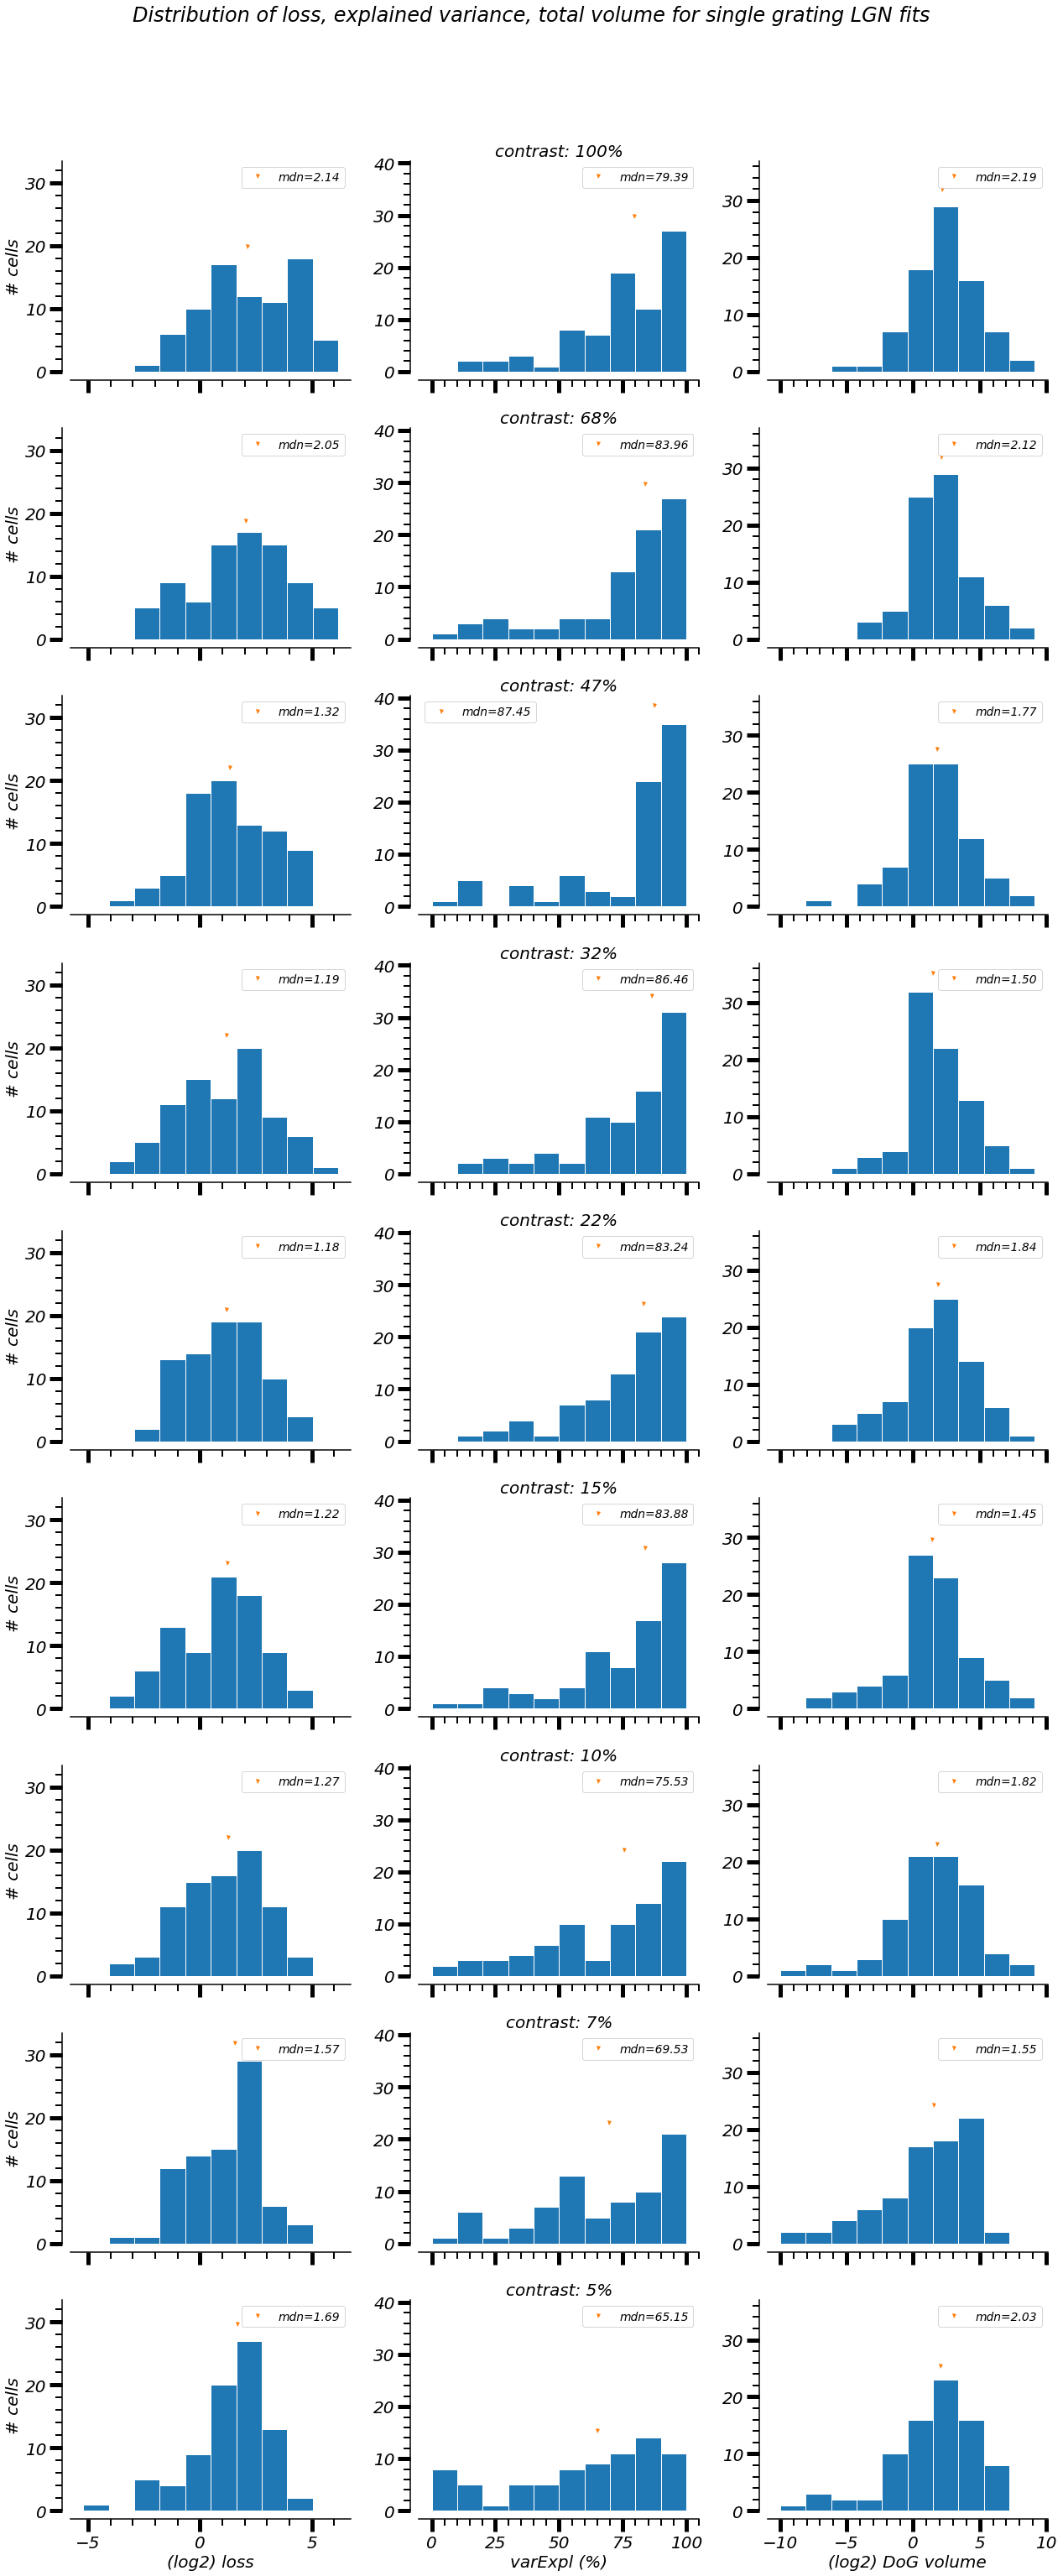

In [1068]:
all_nlls = np.vstack([hf.nan_rm(fits[x]['NLL'][0]) for x in sorted(fits.keys())]);
all_vExps = np.vstack([hf.nan_rm(fits[x]['varExpl'][0]) for x in sorted(fits.keys())]);
# --- get volumes
all_vols = [np.array([hf.dog_total_volume(y, DoGmodel=dog_mod) for y in fits[x]['params'][0]]) for x in sorted(fits.keys())]
all_vols_org = np.vstack([hf.nan_rm(x) for x in all_vols]);

nCons = all_nlls.shape[1]
# hard-coded, but I know these values [just being lazy]
con_vals = np.geomspace(5, 100, nCons)

nrows, ncols = nCons, 3;

# nll, vol will be plotted on log scale
nll_bins = np.log2(np.geomspace(np.min(all_nlls), np.max(all_nlls), 11));
vExp_bins = np.linspace(0,100,11)
vol_bins = np.log2(np.geomspace(np.min(all_vols_org), np.max(all_vols_org), 11));

f, ax = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), sharex='col', sharey='col')

for con in range(nCons):
    
    con_plt = nCons-con-1;
    
    # first, NLL
    vals = ax[con_plt,0].hist(np.log2(all_nlls[:, con]), bins=nll_bins)
    # --- median loss
    mdn = np.nanmedian(np.log2(all_nlls[:,con]));
    ax[con_plt,0].plot(mdn, 1.1*np.max(vals[0]), 'v', label='mdn=%.2f' % mdn)
    # then, varExpl
    vals = ax[con_plt,1].hist(all_vExps[:, con], bins=vExp_bins)
    # --- median var
    mdn = np.nanmedian(all_vExps[:,con]);
    ax[con_plt,1].plot(mdn, 1.1*np.max(vals[0]), 'v', label='mdn=%.2f' % mdn)
    # finally, DoG volume
    vals = ax[con_plt,2].hist(np.log2(all_vols_org[:, con]), bins=vol_bins)
    # --- median vol
    mdn = np.nanmedian(np.log2(all_vols_org[:,con]));
    ax[con_plt,2].plot(mdn, 1.1*np.max(vals[0]), 'v', label='mdn=%.2f' % mdn)
        
    # labels
    if con_plt==(nCons-1):
        # make labels just at the bottom
        ax[con_plt,0].set_xlabel('(log2) loss')
        ax[con_plt,1].set_xlabel('varExpl (%)')
        ax[con_plt,2].set_xlabel('(log2) DoG volume')
    ax[con_plt,1].set_title('contrast: %d%%' % con_vals[con])
    ax[con_plt,0].set_ylabel('# cells')
    for i in range(ncols):
        ax[con_plt,i].legend(fontsize='x-small');
        
sns.despine(offset=10)
f.suptitle('Distribution of loss, explained variance, total volume for single grating LGN fits');
f.tight_layout(rect=[0, 0.03, 1, 0.95])

saveName = "/02_01_loss_vE_vol_byCon_loss_%s.pdf" % loss_str;
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


For both loss functions (Sach's and sqrt) the distributions of loss value and DoG volume are comparable enough, by eye's first approximation, to treat all of the data together. Thus, we can plot the same values, but across all contrasts, and use that to inform our choice of $\lambda$

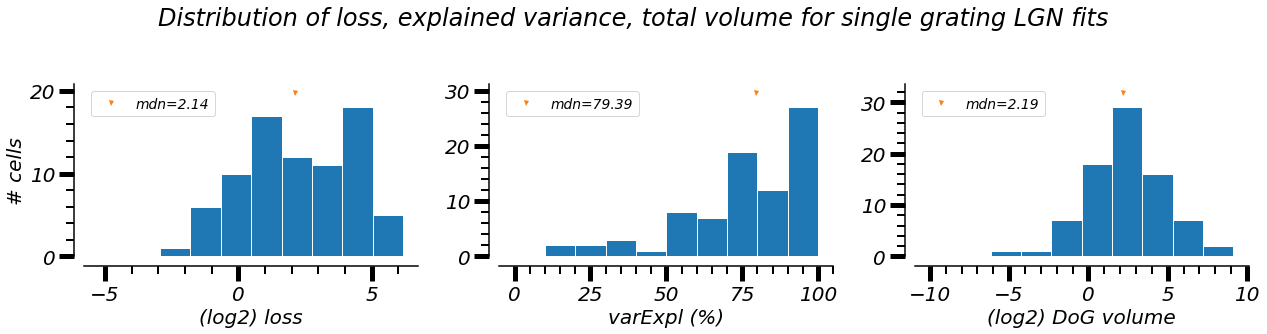

In [1069]:
all_nlls = np.vstack([hf.nan_rm(fits[x]['NLL'][0]) for x in sorted(fits.keys())]);
all_vExps = np.vstack([hf.nan_rm(fits[x]['varExpl'][0]) for x in sorted(fits.keys())]);
# --- get volumes
all_vols = [np.array([hf.dog_total_volume(y, DoGmodel=dog_mod) for y in fits[x]['params'][0]]) for x in sorted(fits.keys())]
all_vols_org = np.vstack([hf.nan_rm(x) for x in all_vols]);

# nll, vol will be plotted on log scale
nll_bins = np.log2(np.geomspace(np.min(all_nlls), np.max(all_nlls), 11));
vExp_bins = np.linspace(0,100,11)
vol_bins = np.log2(np.geomspace(np.min(all_vols_org), np.max(all_vols_org), 11));

nrows, ncols = 1, 3;
f, ax = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), sharex='col', sharey='col')

# first, NLL
vals = ax[0].hist(np.log2(all_nlls[:, con]), bins=nll_bins)
# --- median loss
mdn = np.nanmedian(np.log2(all_nlls[:,con]));
ax[0].plot(mdn, 1.1*np.max(vals[0]), 'v', label='mdn=%.2f' % mdn)
# then, varExpl
vals = ax[1].hist(all_vExps[:, con], bins=vExp_bins)
# --- median var
mdn = np.nanmedian(all_vExps[:,con]);
ax[1].plot(mdn, 1.1*np.max(vals[0]), 'v', label='mdn=%.2f' % mdn)
# finally, DoG volume
vals = ax[2].hist(np.log2(all_vols_org[:, con]), bins=vol_bins)
# --- median vol
mdn = np.nanmedian(np.log2(all_vols_org[:,con]));
ax[2].plot(mdn, 1.1*np.max(vals[0]), 'v', label='mdn=%.2f' % mdn)

# labels
ax[0].set_xlabel('(log2) loss')
ax[1].set_xlabel('varExpl (%)')
ax[2].set_xlabel('(log2) DoG volume')
ax[0].set_ylabel('# cells')
for i in range(ncols):
    ax[i].legend(fontsize='x-small');
        
sns.despine(offset=10)
f.suptitle('Distribution of loss, explained variance, total volume for single grating LGN fits');
f.tight_layout(rect=[0, 0.03, 1, 0.95])

saveName = "/02_02_loss_vE_vol_loss_%s.pdf" % loss_str;
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


##### Now, we get into the actual regularization

KeyError: 'boot_cv_lambdas'

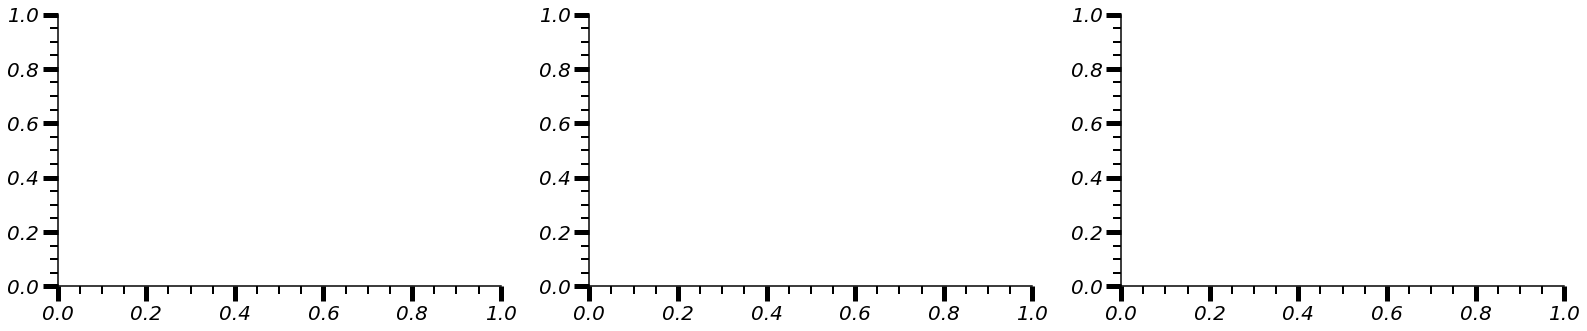

In [1141]:
norm_vals = 0; # normalize the NLL, vExp to the maximum value across all lambdas?

which_op = 0; # if 0, mean; if 1, median

thresh_varExpl = 1; # None or a value (e.g. 1)

nrows, ncols = 1, 3; # will plot loss, varExpl, volume

# keep track of how many we've plotted, close all figures after the first N
i_start = None;
i_curr = None;
n_toShow = 5;

for i in sorted(fits.keys()):
    
    if i_start is None:
        i_start = i;
    i_curr = i;
    
    f, ax = plt.subplots(nrows, ncols, figsize=(ncols*9, nrows*5), sharex=True);
    
    curr_fits = fits[i];
    lambdas = np.array(curr_fits['boot_cv_lambdas']);
    # NOTE: For all, we only consider single gratings (hence [0], i.e. disp=0)
    # train
    nll = curr_fits['boot_NLL_cv_train'];
    nll_train = [np.nanmedian(x[0]) for x in nll] if which_op==1 else [np.nanmean(x[0]) for x in nll]
    vExp = curr_fits['boot_vExp_cv_train'];
    vExp_train = [np.nanmedian(x[0]) for x in vExp] if which_op==1 else [np.nanmean(x[0]) for x in vExp]
    # test
    nll = curr_fits['boot_NLL_cv_test'];
    nll_test = np.array([np.nanmedian(x[0]) for x in nll] if which_op==1 else [np.nanmean(x[0]) for x in nll])
    vExp = curr_fits['boot_vExp_cv_test'];
    vExp_test = [np.nanmedian(x[0]) for x in vExp] if which_op==1 else [np.nanmean(x[0]) for x in vExp]
    
    if norm_vals:
        nll_test = np.divide(nll_test, np.nanmax(nll_test));
        vExp_test = np.divide(vExp_test, np.nanmax(vExp_test));
        nll_train = np.divide(nll_train, np.nanmax(nll_train));
        vExp_train = np.divide(vExp_train, np.nanmax(vExp_train));
        
    # first, plot the loss
    ax[0].scatter(lambdas, nll_test, color='r', label='test');
    ax[0].scatter(lambdas, nll_train, color='k', label='train');
    mn_test_atL0 = np.mean(nll_test[lambdas==0])
    ax[0].axhline(mn_test_atL0, color='r', linestyle='--', alpha=0.4);
    ax[0].set_ylabel('loss');
    # then, the explained variance
    if thresh_varExpl is not None:
        vExp_test = np.maximum(thresh_varExpl, vExp_test)
        vExp_train = np.maximum(thresh_varExpl, vExp_train)
    ax[1].scatter(lambdas, vExp_test, color='r', label='test');
    ax[1].scatter(lambdas, vExp_train, color='k', label='train');
    ax[1].set_ylabel('varExpl');
    # finally, the DoG volume
    vols_perLambda = [];
    for l in fits[i]['boot_cv_params']:
        for c in range(l.shape[2]):
            currs = l[:,0,c];
            vols = [hf.dog_total_volume(x, DoGmodel=1) for x in currs];
        vols_perLambda.append(np.nanmedian(vols) if which_op==1 else np.nanmean(vols));
    ax[2].scatter(lambdas, vols_perLambda, color='k', label='fit volume');
    ax[2].set_ylabel('total DoG volume');

    
    for j in range(ncols):
        ax[j].set_xscale('symlog', linthresh=np.min(lambdas[lambdas>0]));
        ax[j].set_yscale('symlog');
        ax[j].legend(fontsize='x-small');
        ax[j].set_xlabel(r'$\lambda$');
        
    f.suptitle('Cell #%02d' % (i+1));

    sns.despine(offset=5);
    
    # save and close (if plotting all)
    saveName = "/02_03_%s_lambda/cell_%03d.pdf" % (loss_str, i+1);
    curr_loc = os.path.dirname(save_loc + saveName);
    full_save = os.path.dirname(curr_loc);
    if not os.path.exists(curr_loc):
        os.makedirs(curr_loc);
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    pdfSv.savefig(f); # only one figure here...
    pdfSv.close();
    if (i_curr - i_start) >= n_toShow:
        f.clf();
    

### Conclusions
Per discussion with Eero on 21.11.11, my concern - namely, interpretability of the underlying DoG parameters - isn't necessarily solved with regularization. This is borne out by the lack of clear improvement in explained variance or loss in the heldout data across the range of lambda values (i.e. regularization strength). The regularization works as expected, i.e. the total volume reduces as a function of lambda, and there are cells for which a regime exists of unchanged loss/explained variance with reduced DoG volume. Those regimes suggest that the model is poorly paramterized, or degenerate, i.e. multiple parameterizations give the same result, and left unconstrained, the model can sometimes find a parameterization which compensates for a too-strong center with a stronger surround.

# Comparing DoG loss functions, parameterizations; model recovery
To ensure the interpretabilty of the DoG model parameters and/or their derived quantities (e.g. characteristic frequency, relative surround strength, volumes), we can do the following:
1. Ensure that each loss funciton, parameterization gives a similar performance in explained variance and (within a loss function, across parameterizations) a similar loss value.
2. Perform model recovery to see which parameterizations/loss functions result in parameters which are the most unique.

First, load the fits that we'll compare

In [1401]:
loss_types = ['sach', 'sqrt'];
param_types = ['sach', 'tony', 'sachVol'];
param_inds = [1, 2, 4];

fitSumm = dict(); # summaries

base_dir = os.getcwd() + '/';
expDir = 'LGN/'

# NOTE: The below are always gathered at zero dispersion
for lt in loss_types:
    for pt in param_types:
        
        fitName = 'descrFits_211119_%s_%s.npy' % (lt, pt)

        curr = hf.np_smart_load('%s%sstructures/%s' % (base_dir, expDir, fitName));
        
        fitSumm[(lt, pt)] = dict();
        
        # calculate
        loss_mn = np.array([np.nanmean(curr[x]['NLL'][0]) for x in curr.keys()]);
        loss_md = np.array([np.nanmedian(curr[x]['NLL'][0]) for x in curr.keys()]);
        vExp_mn = np.array([np.nanmean(curr[x]['varExpl'][0]) for x in curr.keys()]);
        vExp_md = np.array([np.nanmedian(curr[x]['varExpl'][0]) for x in curr.keys()]);
        
        # save
        fitSumm[(lt, pt)]['loss_mn'] = loss_mn
        fitSumm[(lt, pt)]['loss_md'] = loss_md
        fitSumm[(lt, pt)]['vExp_mn'] = vExp_mn
        fitSumm[(lt, pt)]['vExp_md'] = vExp_md
       

#### Comparing within loss function

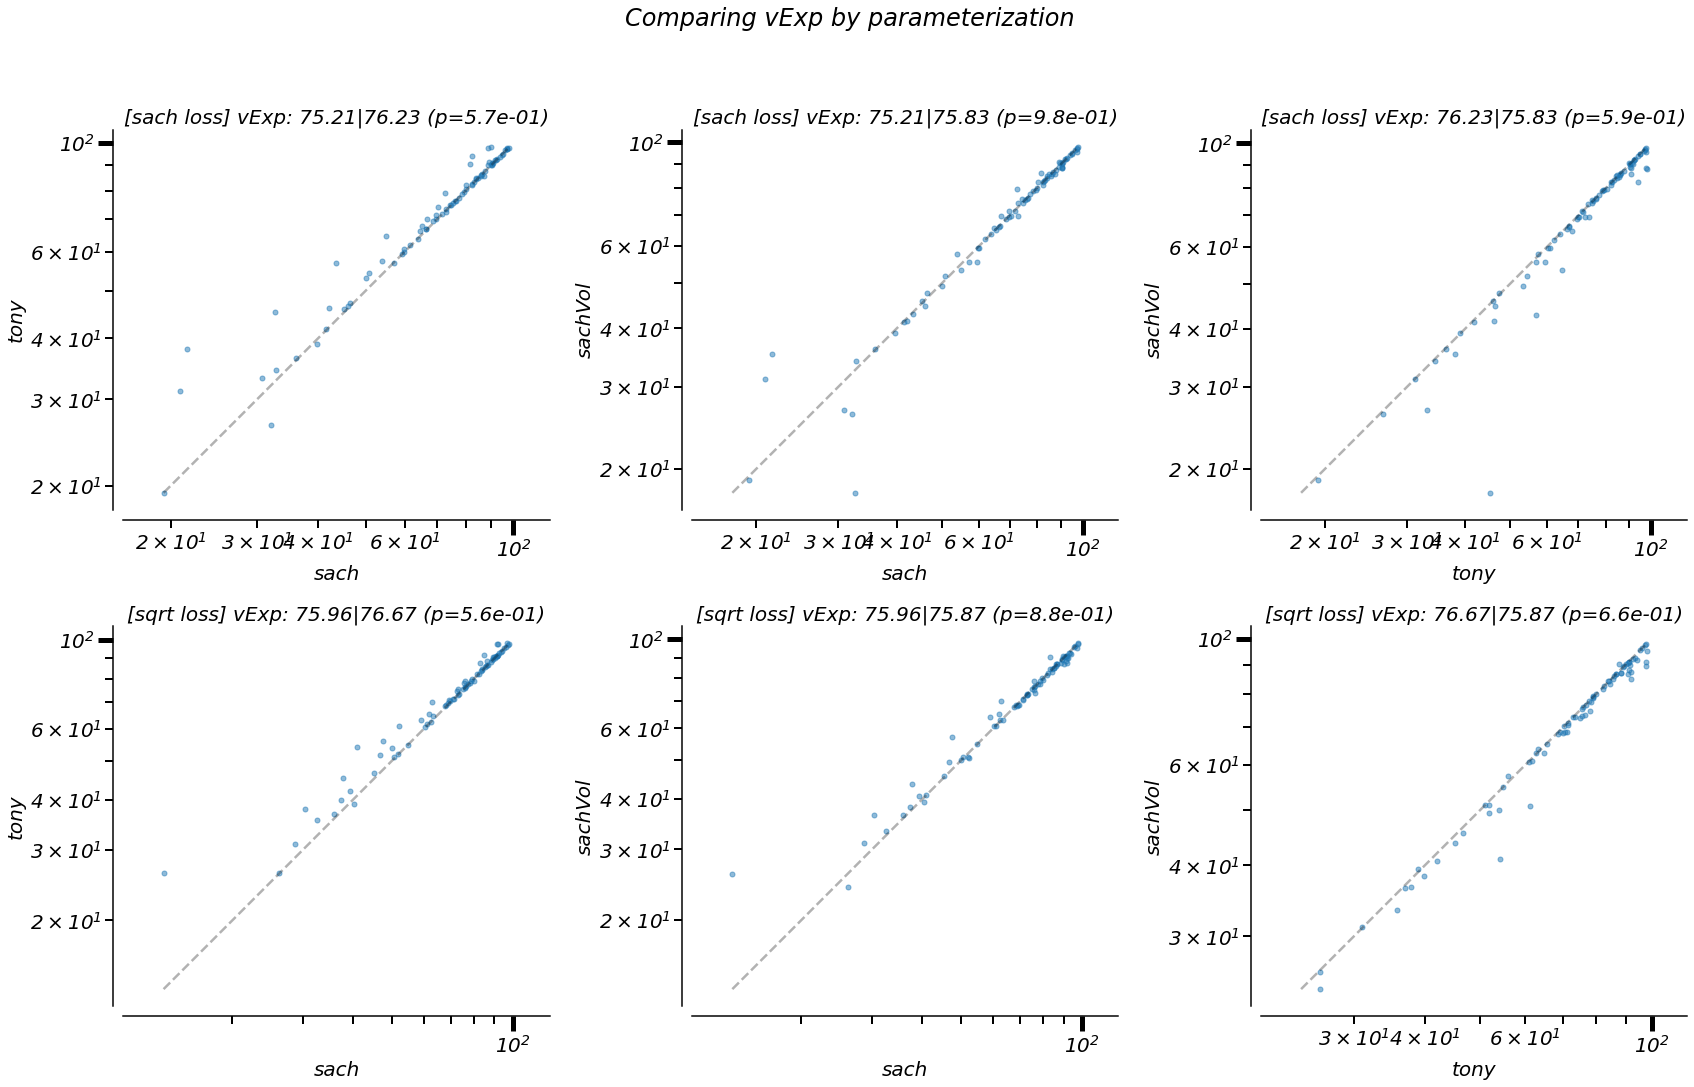

In [1403]:
whichComp = 1; # if 0, then NLL; if 1, then varExpl

compStr = 'loss' if whichComp==0 else 'vExp'

nrows, ncols = 2, 3;
f, ax = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), sharex=False, sharey=False)

for j, lossStr in enumerate(loss_types):

    for i, (keyA, keyB) in enumerate(itertools.combinations(param_types, 2)):

        if whichComp == 0: # loss
            metrA = fitSumm[(lossStr, keyA)]['loss_mn']
            metrB = fitSumm[(lossStr, keyB)]['loss_mn']
        elif whichComp == 1: # varExpl
            metrA = fitSumm[(lossStr, keyA)]['vExp_mn']
            metrB = fitSumm[(lossStr, keyB)]['vExp_mn']

        ax[j, i].scatter(metrA, metrB, alpha=0.5)

        ax[j,i].set_xscale('log');
        ax[j,i].set_yscale('log');
        ax[j,i].set_xlabel('%s' % keyA);
        ax[j,i].set_ylabel('%s' % keyB);#, labelpad=ypad);
        
        # plot unity line
        ovrMin,ovrMax = np.minimum(np.min(metrA), np.min(metrB)), np.maximum(np.max(metrA),np.max(metrB))
        ax[j, i].plot([ovrMin,ovrMax], [ovrMin,ovrMax], 'k--', alpha=0.3)
        
        # do ttest comparing the two...
        ttest = ss.ttest_ind(metrA, metrB);
        ax[j,i].set_title('[%s loss] %s: %.2f|%.2f (p=%.1e)' % (lossStr, compStr, np.nanmedian(metrA), np.nanmedian(metrB), ttest.pvalue));
        ax[j,i].axis('equal')
        
sns.despine(offset=10)
f.suptitle('Comparing %s by parameterization' % compStr);
f.tight_layout(rect=[0, 0.03, 1, 0.95])

saveName = "/03_%02d_%s_lossComp.pdf" % (whichComp+1, compStr);
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...

pdfSv.close()

#### Comparing within parameterization

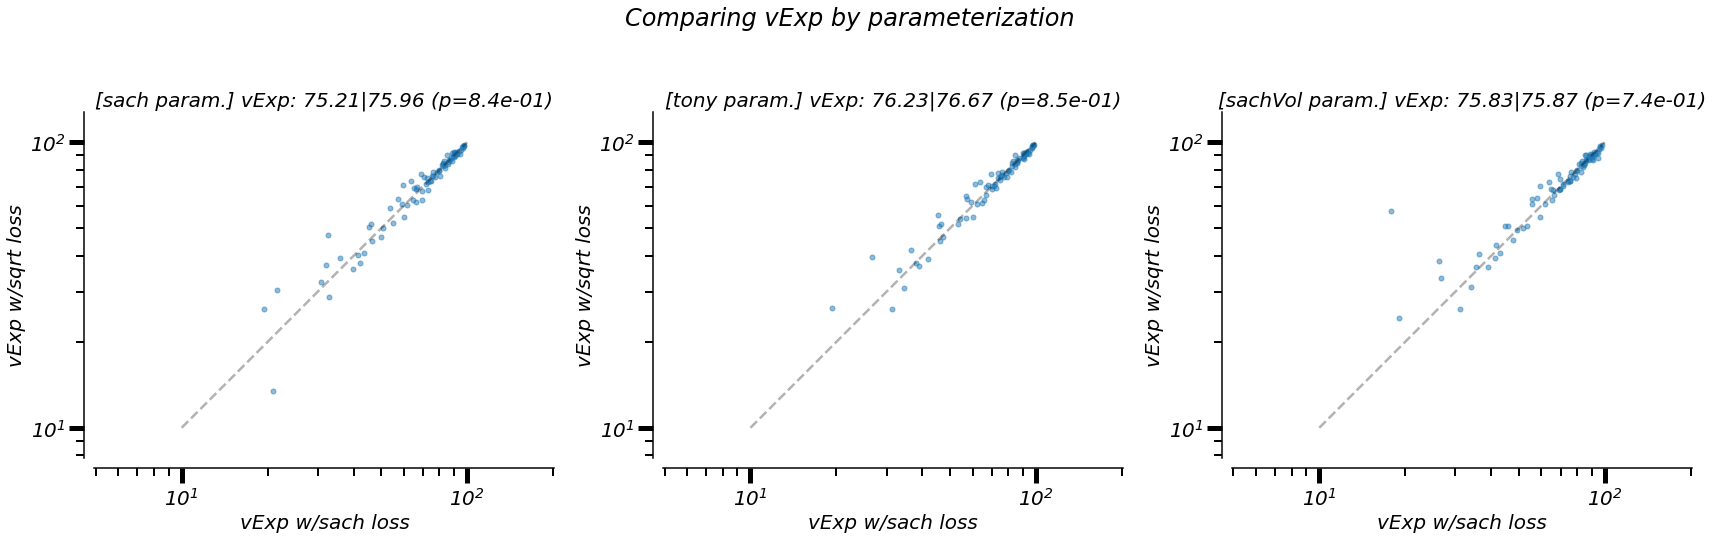

In [1404]:
# NOTE: Cannot compare loss, since within a parameterization, we are comparing across loss functions (cannot do so!)

nrows, ncols = 1, 3;
f, ax = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), sharex=False, sharey=False)

for i, paramStr in enumerate(param_types):
    
    metrA = fitSumm[(loss_types[0], paramStr)]['vExp_mn']
    metrB = fitSumm[(loss_types[1], paramStr)]['vExp_mn']

    ax[i].scatter(metrA, metrB, alpha=0.5)

    ax[i].set_xscale('log');
    ax[i].set_yscale('log');
    ax[i].set_xlabel('vExp w/%s loss' % loss_types[0]);
    ax[i].set_ylabel('vExp w/%s loss' % loss_types[1]);#, labelpad=ypad);

    # plot unity line
    ax[i].plot([10, 100], [10, 100], 'k--', alpha=0.3)
    
    # do ttest comparing the two...
    ttest = ss.ttest_ind(metrA, metrB);
    ax[i].set_title('[%s param.] %s: %.2f|%.2f (p=%.1e)' % (paramStr, compStr, np.nanmedian(metrA), np.nanmedian(metrB), ttest.pvalue));
    ax[i].axis('equal')
        
sns.despine(offset=10)
f.suptitle('Comparing vExp by parameterization');
f.tight_layout(rect=[0, 0.03, 1, 0.95])

saveName = "/03_03_vExp_paramComp.pdf";
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...

pdfSv.close()

Very clearly, there are no substantive differences between the parameterizations, as expected. Next, we should ask if one is more _reliable_ than the others. By that, we mean that the parameters are more uniquely specified.


#### Model recovery

In [1473]:
# Direct parameters
nCells = len(loss_mn); # just take the length of one of the analyses in 03_01 above
pltLog = 1

# keep track of how many we've plotted, close all figures after the first N
i_start = None;
i_curr = None;
    
### Compare by direct params (as opposed to radius/gain/volume parameters)
for cellNum in range(nCells):
        
    if i_start is None:
        i_start = cellNum;
    i_curr = cellNum;   

    nrow, ncol = 2, 2; # gain, radius, volume

    for lt in loss_types:
        for pt,pKey in zip(param_types, param_inds):
            
            fitName = 'descrFits_211121_%s_%s_modRecov.npy' % (lt, pt);
            curr = hf.np_smart_load('%s%sstructures/%s' % (base_dir, expDir, fitName));

            if curr is None or curr==[]:
                continue;

            orig_params = curr[cellNum]['params'][0,-1];
            recov_params = curr[cellNum]['boot_params'][:,0,-1];

            mech = ['c','s']; # center, surround

            f, ax = plt.subplots(nrow,ncol,figsize=(10*ncol,8*nrow))

            for j,mch in enumerate(['center', 'surround']):
                for i,mtr in enumerate(['"gain"', '"r" or "f"']):
                    ref_val = orig_params[2*j+i];
                    ref_val = np.log2(ref_val) if pltLog else ref_val;
                    # recovery
                    rec_vals = np.array([x[2*j+i] for x in recov_params]);
                    rec_vals = np.log2(rec_vals) if pltLog else rec_vals;
                    # then plot
                    ax[j,i].hist(rec_vals)
                    ax[j,i].axvline(ref_val, color='k', linestyle='--')
                    ax[j,i].set_xlabel('%s %s' % (mch,mtr))

            f.suptitle('Model recovery: %s param., %s loss; high contrast' % (pt, lt))

            # save and close (if plotting all)
            saveName = "/03_04_mod_recov_byParam/cell_%03d_%s_%s.pdf" % (cellNum+1, pt, lt);
            curr_loc = os.path.dirname(save_loc + saveName);
            full_save = os.path.dirname(curr_loc);
            if not os.path.exists(curr_loc):
                os.makedirs(curr_loc);
            pdfSv = pltSave.PdfPages(save_loc + saveName);
            pdfSv.savefig(f); # only one figure here...
            pdfSv.close();
            f.clf();


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

In [ ]:
# Output metrics, i.e. gain, radius, volume
pltLog = 1

nrow, ncol = 2, 3; # gain, radius, volume

# keep track of how many we've plotted, close all figures after the first N
i_start = None;
i_curr = None;
    
### Compare by direct params (as opposed to radius/gain/volume parameters)
for cellNum in range(nCells):
        
    if i_start is None:
        i_start = cellNum;
    i_curr = cellNum;  

    for lt in loss_types:
        for pt,pKey in zip(param_types, param_inds):
            
            fitName = 'descrFits_211121_%s_%s_modRecov.npy' % (lt, pt);
            curr = hf.np_smart_load('%s%sstructures/%s' % (base_dir, expDir, fitName));

            if curr is None or curr==[]:
                continue;

            orig_params = curr[cellNum]['params'][0,-1];
            recov_params = curr[cellNum]['boot_params'][:,0,-1];

            metr = ['g','r','v']; # gain, radius, volume
            mech = ['c','s']; # center, surround

            f, ax = plt.subplots(nrow,ncol,figsize=(10*ncol,8*nrow))

            for i,mtr in enumerate(metr):
                for j,mch in enumerate(mech):

                    ref_val = hf.dog_get_param(orig_params, pKey, '%s%s' % (mtr, mch))
                    ref_val = np.log2(ref_val) if pltLog else ref_val;
                    # recovery
                    rec_vals = np.array([hf.dog_get_param(x, pKey, '%s%s' % (mtr, mch)) for x in recov_params]);               
                    rec_vals = np.log2(rec_vals) if pltLog else rec_vals;
                    # then plot
                    ax[j,i].hist(rec_vals)
                    ax[j,i].axvline(ref_val, color='k', linestyle='--')
                    ax[j,i].set_xlabel('%s%s' % (mtr,mch))

            f.suptitle('Model recovery: %s param., %s loss; high contrast' % (pt, lt))

            # save and close (if plotting all)
            saveName = "/03_04_mod_recov_byMetric/cell_%03d_%s_%s.pdf" % (cellNum+1, pt, lt);
            curr_loc = os.path.dirname(save_loc + saveName);
            full_save = os.path.dirname(curr_loc);
            if not os.path.exists(curr_loc):
                os.makedirs(curr_loc);
            pdfSv = pltSave.PdfPages(save_loc + saveName);
            pdfSv.savefig(f); # only one figure here...
            pdfSv.close();
            f.clf();

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


##### Now, model recovery across all contrasts (a different plot from the above)

In [ ]:
# Direct parameters
nCells = len(loss_mn); # just take the length of one of the analyses in 03_01 above

pltLog = 1;

# keep track of how many we've plotted, close all figures after the first N
i_start = None;
i_curr = None;
    
### Compare by direct params (as opposed to radius/gain/volume parameters)
for cellNum in range(nCells):
        
    if i_start is None:
        i_start = cellNum;
    i_curr = cellNum;   

    nrow, ncol = 2, 2; # gain, radius

    for lt in loss_types:
        for pt,pKey in zip(param_types, param_inds):
            
            fitName = 'descrFits_211121_%s_%s_modRecov.npy' % (lt, pt);
            curr = hf.np_smart_load('%s%sstructures/%s' % (base_dir, expDir, fitName));

            if curr is None or curr==[]:
                continue;

            # We only look at zero dispersion here!
            disp = 0;
            
            # find out how many cons there are
            vCons = np.where(~np.isnan(curr[cellNum]['NLL'][disp]))[0];
            conVals = np.geomspace(5, 100, len(vCons)) # FIXED values...

            # create the figure to plot
            f, ax = plt.subplots(nrow,ncol,figsize=(20*ncol,8*nrow))
                
            for c,cVal in zip(vCons, conVals):
                
                orig_params = curr[cellNum]['params'][disp,c];
                recov_params = curr[cellNum]['boot_params'][:,disp,c];

                mech = ['c','s']; # center, surround

                for j,mch in enumerate(['center', 'surround']):
                    for i,mtr in enumerate(['"gain"', '"r" or "f"']):
                        ref_val = orig_params[2*j+i];
                        ref_val = np.log2(ref_val) if pltLog else ref_val;
                        # recovery
                        rec_vals = np.array([x[2*j+i] for x in recov_params]);
                        rec_vals = np.log2(rec_vals) if pltLog else rec_vals;
                        # then plot -- first the distribution of mod. recov estimates, then the reference value
                        # --- default width for violinplot is 0.5 --> we'll make it slightly narrower
                        viol = ax[j,i].violinplot(rec_vals, [np.log2(cVal)], showextrema=False, widths=0.4); 
                        ax[j,i].scatter(np.log2(cVal), ref_val, color='r', marker='D', s=40)
                        
                        # make all the violin stuff black and transparent
                        for vp in viol['bodies']:
                            vp.set_color('black')
                            vp.set_alpha(0.2);
                        
#                         ax[j,i].set_xscale('log');
                        ax[j,i].set_xlabel('log2 Contrast (%)')
                        ax[j,i].set_ylabel('%s %s' % (mch, mtr))
                        
                        
            f.suptitle('Model recovery: %s param., %s loss' % (pt, lt))
            sns.despine(offset=10)
            f.tight_layout(rect=[0, 0.03, 1, 0.95])

            # save and close (if plotting all)
            saveName = "/03_05_mod_recov_byParam_allCon/cell_%03d_%s_%s.pdf" % (cellNum+1, pt, lt);
            curr_loc = os.path.dirname(save_loc + saveName);
            full_save = os.path.dirname(curr_loc);
            if not os.path.exists(curr_loc):
                os.makedirs(curr_loc);
            pdfSv = pltSave.PdfPages(save_loc + saveName);
            pdfSv.savefig(f); # only one figure here...
            pdfSv.close();
            f.clf();


In [ ]:
# Output metrics, i.e. gain, radius, volume
nCells = len(loss_mn); # just take the length of one of the analyses in 03_01 above

pltLog = 1;

# keep track of how many we've plotted, close all figures after the first N
i_start = None;
i_curr = None;
    
### Compare by direct params (as opposed to radius/gain/volume parameters)
for cellNum in range(nCells):
        
    if i_start is None:
        i_start = cellNum;
    i_curr = cellNum;   

    nrow, ncol = 2, 3; # gain, radius, volume

    for lt in loss_types:
        for pt,pKey in zip(param_types, param_inds):
            
            fitName = 'descrFits_211121_%s_%s_modRecov.npy' % (lt, pt);
            curr = hf.np_smart_load('%s%sstructures/%s' % (base_dir, expDir, fitName));

            if curr is None or curr==[]:
                continue;

            # We only look at zero dispersion here!
            disp = 0;
            
            # find out how many cons there are
            vCons = np.where(~np.isnan(curr[cellNum]['NLL'][disp]))[0];
            conVals = np.geomspace(5, 100, len(vCons)) # FIXED values...

            # create the figure to plot
            f, ax = plt.subplots(nrow,ncol,figsize=(20*ncol,8*nrow))
                
            metr = ['g','r','v']; # gain, radius, volume
            mech = ['c','s']; # center, surround

            for c,cVal in zip(vCons, conVals):
                
                orig_params = curr[cellNum]['params'][disp,c];
                recov_params = curr[cellNum]['boot_params'][:,disp,c];

                for i,mtr in enumerate(metr):
                    for j,mch in enumerate(mech):

                        ref_val = hf.dog_get_param(orig_params, pKey, '%s%s' % (mtr, mch))
                        ref_val = np.log2(ref_val) if pltLog else ref_val;
                        # recovery
                        rec_vals = np.array([hf.dog_get_param(x, pKey, '%s%s' % (mtr, mch)) for x in recov_params]);               
                        rec_vals = np.log2(rec_vals) if pltLog else rec_vals;
               
                        # then plot -- first the distribution of mod. recov estimates, then the reference value
                        # --- default width for violinplot is 0.5 --> we'll make it slightly narrower
                        viol = ax[j,i].violinplot(rec_vals, [np.log2(cVal)], showextrema=False, widths=0.4); 
                        ax[j,i].scatter(np.log2(cVal), ref_val, color='r', marker='D', s=40)
                        
                        # make all the violin stuff black and transparent
                        for vp in viol['bodies']:
                            vp.set_color('black')
                            vp.set_alpha(0.2);
                        
#                         ax[j,i].set_xscale('log');
                        ax[j,i].set_xlabel('log2 Contrast (%)')
                        ax[j,i].set_ylabel('%s%s' % (mch, mtr))
                        
                        
            f.suptitle('Model recovery: %s param., %s loss' % (pt, lt))
            sns.despine(offset=10)
            f.tight_layout(rect=[0, 0.03, 1, 0.95])

            # save and close (if plotting all)
            saveName = "/03_05_mod_recov_byMetric_allCon/cell_%03d_%s_%s.pdf" % (cellNum+1, pt, lt);
            curr_loc = os.path.dirname(save_loc + saveName);
            full_save = os.path.dirname(curr_loc);
            if not os.path.exists(curr_loc):
                os.makedirs(curr_loc);
            pdfSv = pltSave.PdfPages(save_loc + saveName);
            pdfSv.savefig(f); # only one figure here...
            pdfSv.close();
            f.clf();
